# Confirmation Bias Project
## Behavioural analyses
#### Experiment 1
This is the first behavioral experiment that I ran.

In [497]:
import hddm

We recommend to run this script in Jupyter Notebook. It is possible to not visualize some plots in JupyterLab

##### Import important functions and libraries

In [147]:
import os, glob
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy
import scipy.stats as stats
from scipy import signal
import seaborn as sns
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf
from statsmodels.stats.anova import AnovaRM
import pingouin as pg
from plotly.subplots import make_subplots
from statsmodels.stats.multicomp import (pairwise_tukeyhsd, MultiComparison)
from matplotlib.lines import Line2D
import statsmodels as sms
#import ptitprince as pt
pd.options.display.max_columns = None # display all the columns in pandas dataframe
import plotly.graph_objects as go
import plotly.express as px

##### Important functions

In [148]:
def RT_filter(x, sd): 
    # this function was used to filter those trials with a RT that are above X standard deviation from the mean
    rt_mean = x['RT'].mean()
    up_lim = rt_mean + sd * x['RT'].std()
    x = x.loc[(x['RT'] < up_lim) & (x['RT'] > 0), : ]
    return x #the same dataframe with RT filtered

def log_reg_fit(x, f): # this function was used to calculate the log linear regression between two vectors
    reg = smf.glm(formula = f, data = x, family=sm.families.Binomial()).fit()
    params = reg.params
    PSE = - reg.params.Intercept/reg.params[1]
    # concatenating parameters
    out = pd.DataFrame({'intercept':[params[0]] , 'weight':[params[1]],'PSE': PSE})
    return out #intercept + weight

def z_RT(x):
    # this function was used to calculate the z score of the RT values from a dataframe 
    rt_mean = x['RT'].mean()
    rt_sd   = x['RT'].std()
    x['RTz'] = (x['RT']- rt_mean)/rt_sd
    x['1/RTz']= 1/x['RT']
    rt_mean1  = x['1/RTz'].mean()
    rt_sd1    = x['1/RTz'].std()
    x['1/RTz']=(x['1/RTz']- rt_mean1)/rt_sd1
    return x

def z_DV(x):
    # this function was used to calculate the z score of the DV values from a dataframe 
    dv_mean = x['DV'].mean()
    dv_sd   = x['DV'].std()
    x['DVz'] = (x['DV']- dv_mean)/dv_sd
    return x

def cartesian(arrays, out=None):
    """
    Examples
    --------
    >>> cartesian(([1, 2, 3], [4, 5], [6, 7]))
    """

    arrays = [np.asarray(x) for x in arrays]
    dtype = arrays[0].dtype

    n = np.prod([x.size for x in arrays])
    if out is None:
        out = np.zeros([n, len(arrays)], dtype=dtype)

    #m = n / arrays[0].size
    m = int(n / arrays[0].size) 
    out[:,0] = np.repeat(arrays[0], m)
    if arrays[1:]:
        cartesian(arrays[1:], out=out[0:m, 1:])
        for j in range(1, arrays[0].size):
        #for j in xrange(1, arrays[0].size):
            out[j*m:(j+1)*m, 1:] = out[0:m, 1:]
    return out

def split_confi(x):
    x.insert(19, 'conf_lvl', 'L')  
    s = np.median(x.confi)
    x.loc[s < x.confi, 'conf_lvl'] = 'H' 
    #x.insert(5, 'conf_mean', s) 
    return x

### Data & variables

In [220]:
# CAUTION !! 
# Change the current path to the folder where you stored the experimental results 


results_path = '/home/freeman/Insync/alexisperez@ub.edu/OneDrive Biz/PROJECTS/Condcision/Behav_data/Behavioral/condcision3reps_same' #windows/main

os.chdir(results_path) # change the current working directory to the results path 

all_df = pd.DataFrame([]) # concatenate all behav subject data together
ddata = pd.DataFrame([]) # concatenate here behav data + dv + orientations


nsubj = 0 # initialize subjects counter

for file in sorted(glob.glob("*.psydat")): 
    subjdata = pd.DataFrame([]) # initialize individual subject data variable container
    pfile =  open(os.path.join(results_path, file),"rb")
    nsubj = nsubj + 1
    dat = pickle.load(pfile)
    for block in dat['main_exp']['Exp_blocks']:
        dvdata = pd.DataFrame(signal.sawtooth(4 * (block['trial_orientations']), 0.5),columns=['d1','d2','d3','d4','d5','d6'])
        ddata = pd.concat([block['data'], dvdata, block['trial_orientations']], axis = 1)
        subjdata = pd.concat([subjdata, ddata], axis = 0)
    
    subjdata.insert(0, 'npar', nsubj)
    
    all_df = pd.concat([all_df, subjdata], axis = 0) #concatenate each new subject

all_df.head(10)


,npar,subj,nblock,ntrial,nrep,cond,DV,resp,r_map,correct,RT,d1,d2,d3,d4,d5,d6,o1,o2,o3,o4,o5,o6
0,1,p02,0,0,0,-1,-0.38,m,0,-1,2.836,-0.443358,-0.174941,-0.977600,-0.653679,0.748394,-0.845183,2.923,0.324,1.562,0.136,2.455,1.510
1,1,p02,0,0,1,-1,-0.38,m,0,-1,0.888,-0.443358,-0.174941,-0.977600,-0.653679,0.748394,-0.845183,2.923,0.324,1.562,0.136,2.455,1.510
2,1,p02,0,0,2,-1,-0.38,z,45,-1,1.236,-0.443358,-0.174941,-0.977600,-0.653679,0.748394,-0.845183,2.923,0.324,1.562,0.136,2.455,1.510
3,1,p02,0,1,0,-1,-0.48,m,45,1,0.834,-0.929736,0.255933,-0.458119,-0.886446,-0.203989,-0.589498,3.114,2.064,1.358,3.097,2.829,1.732
4,1,p02,0,1,1,-1,-0.48,z,0,1,1.042,-0.929736,0.255933,-0.458119,-0.886446,-0.203989,-0.589498,3.114,2.064,1.358,3.097,2.829,1.732
5,1,p02,0,1,2,-1,-0.48,m,45,1,0.701,-0.929736,0.255933,-0.458119,-0.886446,-0.203989,-0.589498,3.114,2.064,1.358,3.097,2.829,1.732
6,1,p02,0,2,0,1,0.38,z,45,1,0.713,0.086828,0.189206,0.501385,0.483560,0.626681,0.491718,1.144,0.467,2.552,2.559,0.932,0.985
7,1,p02,0,2,1,1,0.38,z,45,1,1.103,0.086828,0.189206,0.501385,0.483560,0.626681,0.491718,1.144,0.467,2.552,2.559,0.932,0.985
8,1,p02,0,2,2,1,0.38,z,45,1,0.624,0.086828,0.189206,0.501385,0.483560,0.626681,0.491718,1.144,0.467,2.552,2.559,0.932,0.985
9,1,p02,0,3,0,1,0.38,z,0,-1,0.655,0.789138,-0.088360,-0.037950,0.500395,0.920564,0.244191,2.439,0.358,1.193,2.160,2.325,2.653


### Dataframe experiment 1: coding important variables

In [221]:
df = all_df.copy() # copy tge variable

# relabeling some variables
df['cond'] = all_df['cond'].replace([-1], 0)
df['correct'] = all_df['correct'].replace([-1], 0)

df.insert(5, 'cond-1', 0)    # 0 = previous Diag / 1 = previous Card
df['cond-1'] = df['cond'].shift(1, fill_value  = 0)

# Inserting deci variable
df.insert(9, 'deci', 0)
crit1 = (df['cond']  > 0) & (df['correct'] == 1);    # 0 = diagonal       
crit2 = (df['cond']  < 0) & (df['correct'] == 0);            
crit3 = (df['cond'] == 0) & (df['correct'] == 0);
df.loc[crit1 | crit2 | crit3, 'deci'] = 1 

# Inserting the new necessary columns coding trials properly
df.insert(9, 'deci-1', 0)    # 0 = previous Diag / 1 = previous Card
df.insert(11, 'corr-1', 0) # O = incorrect / 1 = correct
df.insert(7, 'rDV', 0) # rDV (real Decision Variable)
df.insert(10, 'deci-2', 0)    # 0 = 2 previous Diag / 1 = previous Card

# Recoding variables
df['deci-1'] = df['deci'].shift(1, fill_value  = 0) # deci in trial n-1
df['deci-2'] = df['deci-1'].shift(1, fill_value  = 0) # deci in trial n-2
df['corr-1'] = df['correct'].shift(1, fill_value  = 0) # correct in trial n-1



df['rDV'] = np.mean(df.iloc[:,17:23], axis = 1) # average DV
df.head(50)


df.reset_index(drop=True, inplace=True)

## df['nrep'] = df['nrep'].astype('category')
df['npar'] = df['npar'].astype('category')
df['nblock'] = df['nblock'].astype('category')
df['cond-1'] = df['cond-1'].astype('category')
df['deci-1'] = df['deci-1'].astype('category')
df['deci-2'] = df['deci-2'].astype('category')


### Reaction Times 
##### Filter those responses with RTs larger than 4 sd

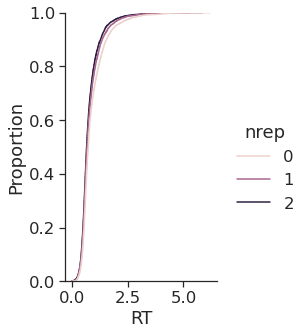

In [222]:
# RTs after apply filter
df_rt = df.groupby(['npar'], group_keys = False).apply(RT_filter, sd = 4)

sns.displot(
    data=df_rt, x="RT", hue="nrep",
     height=5, aspect=.7,  kind="ecdf"
)

In [223]:
npar_labels

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 26])

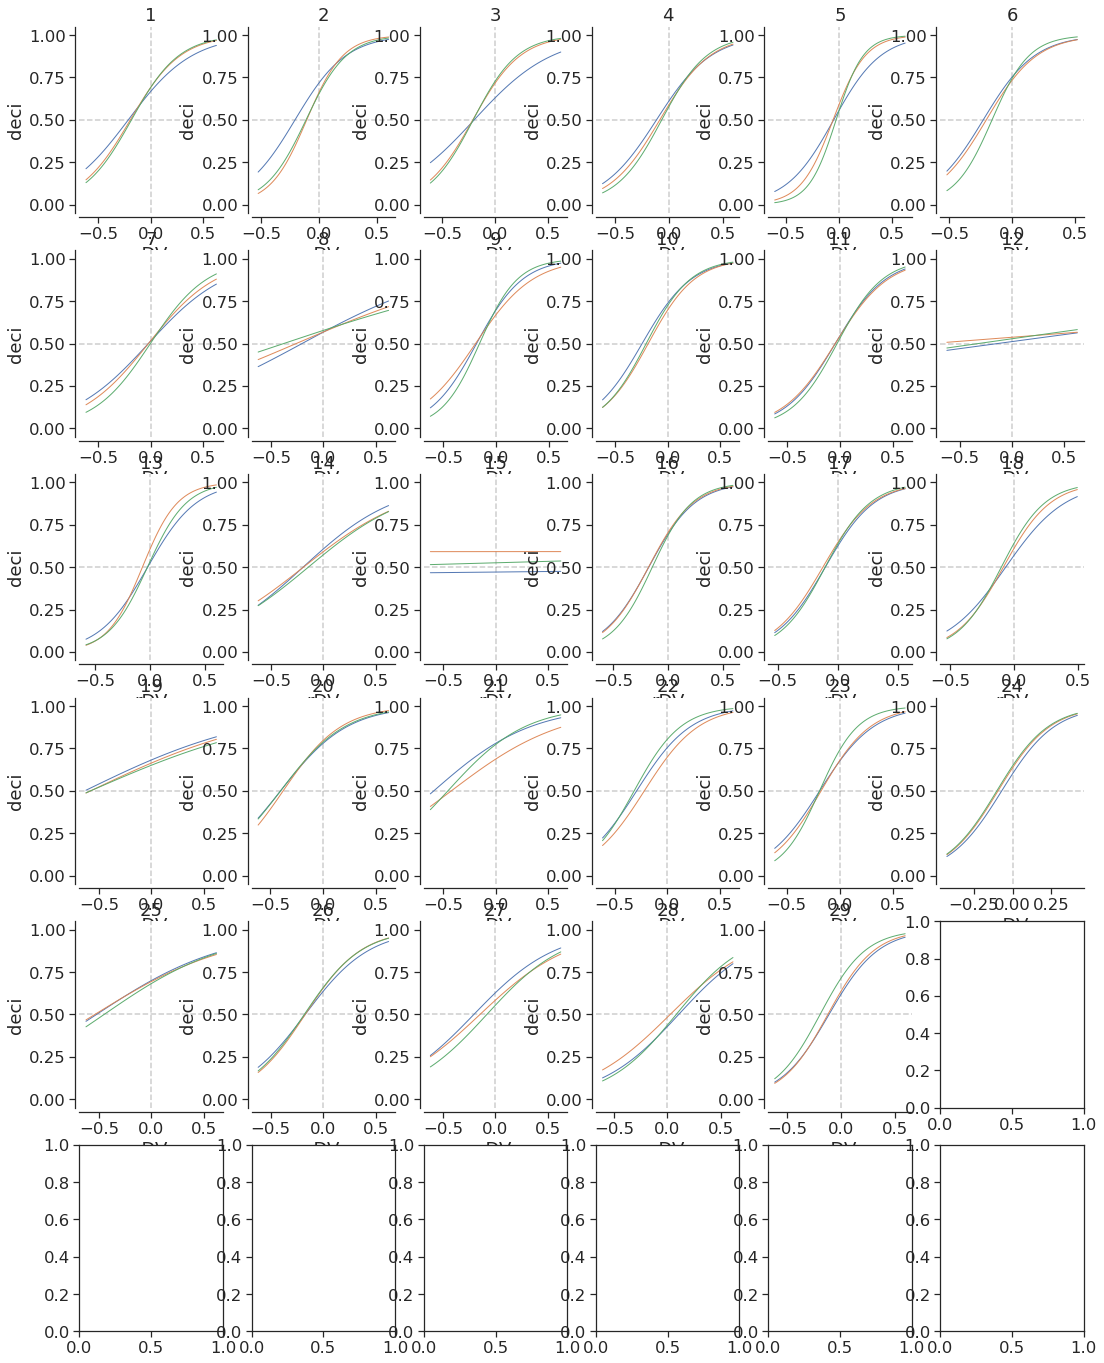

In [224]:
nprows = 6 
npcols = 6

nrep_labels = np.unique(df.nrep) #nrep
npar_labels = np.unique(df.npar) #npar


fig, axes = plt.subplots(nprows, npcols, figsize=(18, 24))
#fig.tight_layout() # improving the space
p = cartesian((np.arange(0,nprows), np.arange(0,npcols)))

for i in npar_labels: #for loop to compute the average by each participant
    df2 = df.loc[df.npar == i,:]
    axes[p[i-1,0],p[i-1,1]].axvline(0, ls='--', color= 'black', alpha=0.2)
    axes[p[i-1,0],p[i-1,1]].axhline(0.5, ls='--', color= 'black', alpha=0.2)
    axes[p[i-1,0],p[i-1,1]].title.set_text(df2.iloc[0,0])
    sns.despine(ax=axes[p[i-1,0],p[i-1,1]],offset=4); # , trim=True
    for cell in nrep_labels:
            #sns.set_palette(mycol)
            sns.regplot(ax=axes[p[i-1,0],p[i-1,1]],x="rDV", y="deci",  data=df2.loc[df2.nrep == cell,:],
               logistic=True, y_jitter=0, scatter_kws={'alpha':0}, ci=True, n_boot=1,  label=cell,  truncate=True, 
                             line_kws ={'alpha':0.95, 'lw':1}); #mean all subject
    

#plt.ylabel('p(diagonal)', fontsize = 25, labelpad=20); plt.yticks(np.arange(0, 1.1, step=0.25), fontsize = 15) 
#axes[1].plt.xlabel('Decision Variable', fontdict={'size':25}, labelpad=20); 
#axes[1].plt.xticks(np.arange(-0.6, 0.61, step=0.3), fontsize = 15)

In [225]:
formula = "deci ~ rDV"
log_par = df.groupby(['subj', 'nrep']).apply(log_reg_fit, formula)
log_par.reset_index(inplace = True)
log_par.head(5)
# here it seems that visual inspection shows that p13 and p15 were pretty bad
log_par[log_par.weight < 0]

#mean_w = np.mean(log_par.weight)
#std_w  = np.std(log_par.weight)
#log_par.weight > (mean_w + 2*std_w)

,subj,nrep,level_2,intercept,weight,PSE


### Removing bad participants

In [226]:
df = df.loc[(df.npar != 25),:] #she was very distracted and confused the keys
df.reset_index(drop=True, inplace=True) # reset the row indexes of the pandas dataframe

##### Dataset with good participants

### Congruency between series of stimuli

##### Dflong for previous orientations and stimuli

In [227]:
# df to long format
dflong = pd.melt(df, id_vars=['subj','nblock','ntrial','nrep','cond-1','cond', 'deci-2','deci-1','deci', 'corr-1', 'correct','RT'], value_vars=['d1', 'd2', 'd3', 'd4', 'd5', 'd6'])
dflong.shape
dflong.rename(columns={'variable' : "stim", 'value' : 'dv'}, inplace=True)

out = pd.melt(df, id_vars=['subj','nblock','ntrial','nrep','cond-1','cond', 'deci-2','deci-1','deci', 'corr-1', 'correct','RT'], value_vars=['o1', 'o2', 'o3', 'o4', 'o5', 'o6'])
dflong['orient'] = out.value
dflong.orient = np.rad2deg(dflong.orient) # transform to degrees
del out

dflong = dflong.sort_values(['nblock','subj','ntrial','nrep',],ascending=[True,True,True,True]) # reorder variables
dflong.reset_index(drop=True, inplace=True)
dflong.insert(5, "stim_cond", "D")
dflong.loc[(dflong.dv < 0), "stim_cond"]  = "C"


dflong.insert(7, 'cong_deci', "I") # if stim is congruent with previous repetition decosion category
# an stimuli is expected when the previous dv and previous deci were the same (i.e.DV==D & pre_deci == D)
dflong.loc[(dflong['deci-1'] == 0) & (dflong.stim_cond == 'C') | (dflong['deci-1'] == 1) & (dflong.stim_cond == 'D'), "cong_deci"]  = "C"



dflong.insert(8, 'cong_stim', 'I') # if stim is congruent with previous repetition mean category
dflong.loc[(dflong['cond-1'] == 0) & (dflong.stim_cond == 'C') | (dflong['cond-1'] == 'D') & (dflong.stim_cond == 'D'), 'cong_stim'] = 'C'

# relabeling variables
#dflong["cond-1"].replace({0: "C", 1: "D"}, inplace=True)
#dflong["deci"].replace({0: "C", 1: "D"}, inplace=True)
#dflong["deci-1"].replace({0: "C", 1: "D"}, inplace=True)
#dflong["deci-2"].replace({0: "C", 1: "D"}, inplace=True)


dflong['ov'] = signal.sawtooth(2*np.deg2rad(dflong.orient), 0.5) # orientation variable (here I define an ov to make stimuli that differ by less of 45 degrees or more than 135 as similar)
# plt.scatter(dflong.orient,dflong['ov']) # see here


dflong.head(5)

,subj,nblock,ntrial,nrep,cond-1,stim_cond,cond,cong_deci,cong_stim,deci-2,deci-1,deci,corr-1,correct,RT,stim,dv,orient,ov
0,p02,0,0,0,0,C,0,C,C,0,0,1,0,0,2.836,d1,-0.443358,167.475564,-0.721679
1,p02,0,0,0,0,C,0,C,C,0,0,1,0,0,2.836,d2,-0.174941,18.563833,-0.587470
2,p02,0,0,0,0,C,0,C,C,0,0,1,0,0,2.836,d3,-0.977600,89.496008,0.988800
3,p02,0,0,0,0,C,0,C,C,0,0,1,0,0,2.836,d4,-0.653679,7.792226,-0.826839
4,p02,0,0,0,0,D,0,I,I,0,0,1,0,0,2.836,d5,0.748394,140.661139,-0.125803


In [228]:
# Adding decision variable difference & congruency between stim
out = np.diff(dflong.dv, prepend = 0)  # to maintain the matrix size I fill the dataframe with an irrelevant first value
out = np.absolute(out)
absdiffDV = out

stim_dec = dflong.dv.copy()
stim_dec = stim_dec.to_numpy()
# Simplify the labels
stim_dec[stim_dec > 0] = 1
stim_dec[stim_dec < 0] = 0
diffDV = np.absolute(np.diff(stim_dec, prepend = 0)) #  change = 1, repeated = 0

# Adding physical orientation variable difference & congruency between stim

out = np.diff(dflong.ov, prepend = 0)  # to maintain the matrix size I fill the dataframe with an irrelevant first value
out = np.absolute(out)
absdiff_stim_ori = out

stim_ori = dflong.ov.copy()
stim_ori = stim_ori.to_numpy()
# Simplify the labels
stim_ori[stim_ori > 0] = 1
stim_ori[stim_ori < 0] = 0
diffstim_ori= np.absolute(np.diff(stim_ori, prepend = 0))


# Merging all the datasets
dflong_seq = pd.concat([dflong, pd.Series(absdiffDV, dtype=np.int32, name='abs_diffDV'), pd.Series(diffDV, dtype=np.int32, name='cong_stim_DV'),pd.Series(stim_ori, dtype=np.int32, name='stim_cat_OV'),pd.Series(stim_ori, dtype=np.int32, name='abs_diffOV'), pd.Series(diffstim_ori, dtype=np.int32, name='cong_stim_OV')], axis=1).copy()

dflong_seq = dflong_seq.loc[dflong_seq['stim'] != "d1"] # now I remove d1 as it is not informative and it would add noise to this analysis
dflong_seq.head(2)

,subj,nblock,ntrial,nrep,cond-1,stim_cond,cond,cong_deci,cong_stim,deci-2,deci-1,deci,corr-1,correct,RT,stim,dv,orient,ov,abs_diffDV,cong_stim_DV,stim_cat_OV,abs_diffOV,cong_stim_OV
1,p02,0,0,0,0,C,0,C,C,0,0,1,0,0,2.836,d2,-0.174941,18.563833,-0.58747,0.268418,0,0,0,0
2,p02,0,0,0,0,C,0,C,C,0,0,1,0,0,2.836,d3,-0.977600,89.496008,0.98880,0.802660,0,1,1,1


Confidence analyses

__Calculating mean DV and confi per condition__ 

Checking wether participants performed better in repeated or nonrepeated trials

In [229]:
df.head(5)

,npar,subj,nblock,ntrial,nrep,cond-1,cond,rDV,DV,resp,deci-2,deci-1,deci,corr-1,r_map,correct,RT,d1,d2,d3,d4,d5,d6,o1,o2,o3,o4,o5,o6
0,1,p02,0,0,0,0,0,-0.391061,-0.38,m,0,0,1,0,0,0,2.836,-0.443358,-0.174941,-0.977600,-0.653679,0.748394,-0.845183,2.923,0.324,1.562,0.136,2.455,1.510
1,1,p02,0,0,1,0,0,-0.391061,-0.38,m,0,1,1,0,0,0,0.888,-0.443358,-0.174941,-0.977600,-0.653679,0.748394,-0.845183,2.923,0.324,1.562,0.136,2.455,1.510
2,1,p02,0,0,2,0,0,-0.391061,-0.38,z,1,1,1,0,45,0,1.236,-0.443358,-0.174941,-0.977600,-0.653679,0.748394,-0.845183,2.923,0.324,1.562,0.136,2.455,1.510
3,1,p02,0,1,0,0,0,-0.468642,-0.48,m,1,1,0,0,45,1,0.834,-0.929736,0.255933,-0.458119,-0.886446,-0.203989,-0.589498,3.114,2.064,1.358,3.097,2.829,1.732
4,1,p02,0,1,1,0,0,-0.468642,-0.48,z,1,0,0,1,0,1,1.042,-0.929736,0.255933,-0.458119,-0.886446,-0.203989,-0.589498,3.114,2.064,1.358,3.097,2.829,1.732


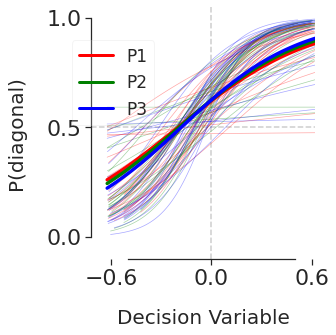

In [230]:
mycol = ["red", "green","blue"]
sns.set_palette(mycol)

fig, axes = plt.subplots(1, 1, figsize=(5, 5))
nrep_labels = np.unique(df.nrep) #nrep
npar_labels = np.unique(df.npar) #npar


axes.axvline(0, ls ='--', color= 'black', alpha=0.2)
axes.axhline(0.5, ls ='--', color= 'black', alpha=0.2)

for i in npar_labels: #for loop to compute the average by each participant
    df2=df.loc[(df.npar == i) ,:]
    for cell in nrep_labels:
        sns.set_palette(mycol)
        sns.regplot(x="rDV", y="deci",  data=df2.loc[df2.nrep == cell,:],
           logistic=True, y_jitter=0, scatter_kws={'alpha':0}, ci=True, n_boot=1, ax = axes, label=cell,  truncate=True, 
                         line_kws ={'alpha':0.35, 'lw':0.7}); #mean all subject

for cell in nrep_labels: #for loop to compute the plot by the average sample
    sns.set_palette(mycol)
    sns.regplot(x="rDV", y="deci",  data=df.loc[(df.nrep == cell) ,:],
           logistic=True, y_jitter=0, scatter_kws={'alpha':0}, ci=True, n_boot=1,   ax = axes, label=cell,  truncate=True, 
                     line_kws ={'lw':3.4});
#sns.despine(offset=1, trim=True, ax = axes[j]);
sns.despine(ax= axes, offset=0.5, trim = True);

axes.set_ylabel('P(diagonal)', fontsize = 20, labelpad=20); #axes[j].set_yticks(np.arange(0, 1.1, step=0.25), fontsize = 15) 
axes.set_xlabel('Decision Variable', fontdict={'size':20}, labelpad=20); 

#xticks = [-0.6,-0.3,0,0.3,0.6] #np.round(np.arange(-0.9, 0.6, step=0.3),decimals = 2)
#yticks = np.arange(-0., 1.1, step=0.25)

axes.set_xlim(-0.72,0.62)
axes.set_xticks([-0.6,0,0.6]) 

axes.tick_params(axis='x', labelsize=22)   
axes.set_yticks([0.0,0.5,1]) 
axes.set_ylim(-0.1,1.05)
axes.tick_params(axis='y', labelsize=22) 


lines = [Line2D([0], [0], color=c, linewidth=3) for c in mycol]; labels = ['P1', 'P2', 'P3']; 
plt.legend(lines, labels, bbox_to_anchor=(0.32,0.9), fontsize=17, framealpha= 0.2)
fig.tight_layout()
#plt.savefig('deci_x_nrep.png',bbox_inches='tight')


Logisitc regression model with number of presentation

In [231]:
# make the model to estimate if there are statistical differences in weight or the intercept
formula = "deci ~ rDV"
log_reg_nrep = df.groupby(['subj', 'nrep']).apply(log_reg_fit, formula) 
log_reg_nrep.reset_index(inplace = True)
log_reg_nrep.tail(5)

,subj,nrep,level_2,intercept,weight,PSE
73,p29,1,0,-0.068291,2.474105,0.027602
74,p29,2,0,-0.257733,3.065616,0.084072
75,p30,0,0,0.484516,4.372556,-0.110808
76,p30,1,0,0.562673,4.631015,-0.121501
77,p30,2,0,0.915368,4.737712,-0.193209


<font size="4"> _Statistical tests for Weight._

In [232]:
dat = log_reg_nrep
aov = AnovaRM(dat, 'weight', 'subj', within=['nrep'])
resaov = aov.fit()
print(resaov) 

              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
nrep 14.3865 2.0000 50.0000 0.0000



In [233]:
#post-hoc t-test
pg.pairwise_ttests(dv='weight', within= ['nrep'], subject='subj', padjust='bonf', 
                    effsize = 'cohen', data=log_reg_nrep) 

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,cohen
0,nrep,0,1,True,True,-2.594944,25.0,two-sided,0.015604,0.046812,bonf,3.253,-0.241579
1,nrep,0,2,True,True,-4.827420,25.0,two-sided,0.000058,0.000175,bonf,434.139,-0.465235
2,nrep,1,2,True,True,-3.184199,25.0,two-sided,0.003863,0.011588,bonf,10.611,-0.216249


In [234]:
dat = log_reg_nrep
aov = AnovaRM(dat, 'PSE', 'subj', within=['nrep'])
resaov = aov.fit()
print(resaov) 

              Anova
     F Value Num DF  Den DF Pr > F
----------------------------------
nrep  1.2324 2.0000 50.0000 0.3003



In [235]:
#post-hoc t-test
pg.pairwise_ttests(dv='PSE', within= ['nrep'], subject='subj', padjust='bonf', 
                    effsize = 'cohen', data=log_reg_nrep) 

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,cohen
0,nrep,0,1,True,True,1.052258,25.0,two-sided,0.302746,0.908239,bonf,0.341,0.187217
1,nrep,0,2,True,True,0.053335,25.0,two-sided,0.957889,1.000000,bonf,0.207,0.004999
2,nrep,1,2,True,True,-1.387292,25.0,two-sided,0.177597,0.532791,bonf,0.487,-0.182166


# Parameters
Plotting weights and PSE

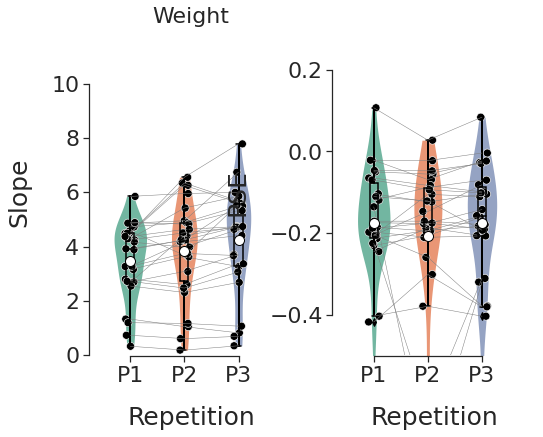

In [236]:
sns.set(style="ticks",font_scale=2)

dat = log_reg_nrep
ort = "v"; 
pal = "Set2"
dx = "nrep"; dy = "weight"; ort = "v"; pal = pal; sigma = .5
f, axes = plt.subplots(1,2,figsize=(8, 6))

# PLOTTING INTERCEPT


dat = log_reg_nrep
sns.boxplot( x = dx, y = dy, data = dat, color = "black"
      ,width = .15, zorder = 2, showcaps = True,  showmeans=True,
            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"},
      boxprops = {'facecolor':'None', "zorder":2}, showfliers=True,
      whiskerprops = {'linewidth':2, "zorder":2}, 
      saturation = 0.1, orient = ort, ax = axes[0])

sns.stripplot(x = dx, y = dy, data = dat,  color = "black", 
      edgecolor = "white",size = 8, linewidth = 0.6, jitter = 1, zorder = 2,
      orient = ort, ax = axes[0])

sns.violinplot( x = dx, y = dy, data = dat, palette = pal,split=True,
     bw = 0.5, cut = 0.0,scale = "area", width = .6, 
     inner = None, orient = ort, linewidth = 0, zorder = 0, ax = axes[0])

sns.lineplot(x = dx, y= dy, data=dat, units= "subj" , estimator=None, color = 'grey',linewidth = 0.5, ax = axes[0])


axes[0].set_xlim([-0.75, 3])
axes[0].set_xticks([0,1,2])
axes[0].set_xticklabels(['P1','P2','P3'])
axes[0].set_xlabel('Repetition', fontdict={'size':25}, labelpad=20); 


axes[0].set_ylim([0, 12])
axes[0].set_yticks(np.arange(0, 12, step=2))
axes[0].set_ylabel('Slope', fontsize = 25, labelpad=20);

axes[0].tick_params(axis='x', labelsize=22) 
axes[0].tick_params(axis='y', labelsize=22)  
axes[0].set_title('Weight',fontsize = 22)
sns.despine(offset = 1,  trim=True, ax = axes[0]);

dat = log_reg_nrep    
# NOW I PLOT THE INTERCEPT
dy = "PSE"
#dy = "intercept"

sns.boxplot( x = dx, y = dy, data = dat, color = "black"
      ,width = .15, zorder = 2, showcaps = True,  showmeans=True,
            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"},
      boxprops = {'facecolor':'None', "zorder":2}, showfliers=True,
      whiskerprops = {'linewidth':2, "zorder":2}, 
      saturation = 0.1, orient = ort, ax = axes[1])

sns.stripplot(x = dx, y = dy, data = dat,  color = "black", 
      edgecolor = "white",size = 8, linewidth = 0.6, jitter = 1, zorder = 2,
      orient = ort, ax = axes[1])

sns.violinplot( x = dx, y = dy, data = dat, palette = pal,split=True,
     bw = 0.5, cut = 0.0,scale = "area", width = .6, 
     inner = None, orient = ort, linewidth = 0, zorder = 0, ax = axes[1])

#ax = sns.pointplot(x= dx, y= dy, data=dat, color = 'grey', errwidth = 0, size = 10, join = False, zorder = 8)
sns.lineplot(x = dx, y= dy, data=dat, units= "subj" , estimator=None, color = 'grey',linewidth = 0.5, ax = axes[1])


axes[1].set_xlim([-0.75, 3])
axes[1].set_xticks([0,1,2])
axes[1].set_xticklabels(['P1','P2','P3'])
axes[1].set_xlabel('Repetition', fontdict={'size':25}, labelpad=20); 

axes[1].set_ylim([-0.5, 0.3])
axes[1].set_yticks(np.arange(-0.4, 0.2, step=0.2))
axes[1].set_ylabel('PSE', fontsize = 25, labelpad=20);

axes[1].tick_params(axis='x', labelsize=22) 
axes[1].tick_params(axis='y', labelsize=22)  
#axes[1].set_title('PSE',fontsize = 22)
sns.despine(offset = 1,  trim=True, ax = axes[1]);


<font size="5"> _Figure 3A. Logistic regression fits for each presentation separated by cardinal & diagonal._

## Effect of previous decision in the current trial decision

In [237]:
formula = "deci ~ rDV"

subjs = np.unique(df.subj)

for isub in subjs:
    df_subj = df[df.subj == isub] # s16 does not converge
    log_reg_preDeci = df_subj.groupby(['nrep', 'deci-1']).apply(log_reg_fit, formula)
    
    

In [238]:
log_reg_preDeci[(log_reg_preDeci.weight < 0)] # negative weights indicate a problem

,,,intercept,weight,PSE
nrep,deci-1,,,,


In [239]:
np.unique(df_subj.subj)

array(['p30'], dtype=object)

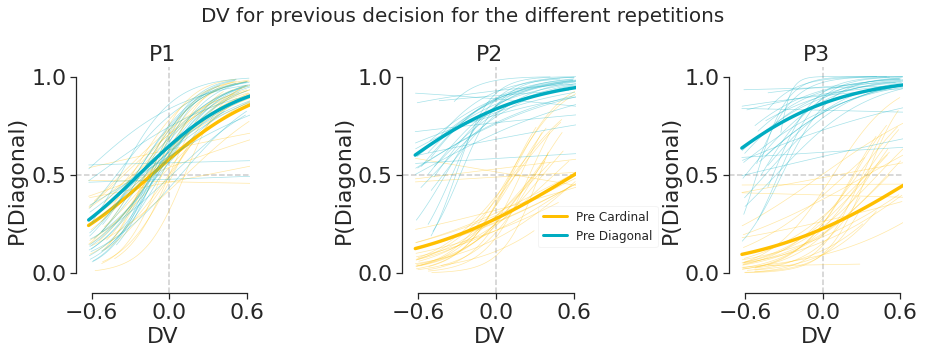

In [240]:
sns.set(font_scale = 1, style = 'ticks') 
mycol = ['#ffbf00' , '#00acc1'] #cardinal #diagonal
sns.set_palette(mycol)

titles = ['P1', 'P2', 'P3']
pre_deci_labels = np.unique(df['deci-1'])     #pre_deci
nreps = np.unique(df['nrep'])     #nreps


df_subj = df.copy() # [(df.subj != 's16') & (df.subj != 's10') & (df.subj != 's22') ] # s16 does not converge amd the others have negative weights
#df_subj = df[df.subj != 's22'] # s16 does not converge
fig, axes = plt.subplots(1, 3, figsize=(13, 5))
fig.suptitle("DV for previous decision for the different repetitions", fontsize=20)

for j in nreps:
    axes[j].axvline(0, ls='--', color= 'black', alpha = 0.2)
    axes[j].axhline(0.5, ls='--', color= 'black', alpha = 0.2)
    for cell in pre_deci_labels:
        for i in npar_labels: #this for loop makes the plot for each participant 
            dati = df_subj[(df_subj.npar == i) & (df_subj['deci-1'] == cell) & (df_subj.nrep == j)].copy()#df.loc[(df.npar == i) & (df['deci-1'] == cell) & (df.nrep == j),:]
            sns.regplot(x="rDV", y="deci",  data= dati,
               logistic=True, y_jitter=0, scatter_kws={'alpha':0}, ci=True, n_boot=1,  
                              label=cell,  truncate=True, line_kws ={'alpha':0.35, 'lw':0.7}, ax = axes[j], color = mycol[cell]);

        dat = df_subj[(df_subj['deci-1'] == cell) & (df_subj.nrep == j) ].copy()
        sns.regplot(x="rDV", y="deci",  data= dat,
               logistic=True, y_jitter=.0, scatter_kws={'alpha':0}, ci=True, n_boot=1,  
                          label=cell, truncate=True, line_kws={'lw':3.4}, ax = axes[j], color = mycol[cell]);

    # Tweaking subplots
    axes[j].set_title(titles[j],fontsize = 22)

    axes[j].set_xlabel('DV', fontsize = 22)
    axes[j].set_ylabel('P(Diagonal)', fontsize = 22)

    axes[j].set_xlim(-0.72,0.62)
    axes[j].set_xticks([-0.6,0,0.6]) 

    axes[j].tick_params(axis='x', labelsize=22)   
    axes[j].set_yticks([0.0,0.5,1]) 
    axes[j].set_ylim(-0.1,1.05)
    axes[j].tick_params(axis='y', labelsize=22) 
    #axes[j].xticks(np.arange(-0.6, 0.61, step=0.3), fontsize = 25); 
    sns.despine(ax= axes[j], offset=0.5, trim = True);

labels = ['Pre Cardinal', 'Pre Diagonal']; 
lines = [Line2D([0], [0], color=c, linewidth=3) for c in mycol]; 
axes[1].legend(lines, labels, bbox_to_anchor=(0.745,0.175), fontsize=12, framealpha= 0.2)

#plt.setp(ax.get_xticklabels(), fontsize=12, fontweight="bold", 
#         horizontalalignment="left")       
        #fig[j].title('P1', fontsize= 35); 

#subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
fig.tight_layout()
#axes[0].ylabel('p(diagonal)', fontsize = 20, labelpad=20); axes[0].yticks(np.arange(0, 1.1, step=0.25), fontsize = 25); plt.xlabel(' ', fontsize = 0)


<font size="3"> _Check whether differences are statistically significant._

Logisitc regression model with previous decision by each presentation

In [241]:
np.unique(df.subj)

array(['p02', 'p03', 'p04', 'p05', 'p06', 'p07', 'p08', 'p09', 'p10',
       'p11', 'p12', 'p13', 'p14', 'p15', 'p17', 'p18', 'p19', 'p20',
       'p21', 'p22', 'p24', 'p25', 'p27', 'p28', 'p29', 'p30'],
      dtype=object)

In [242]:
formula = "deci ~ rDV"
#df_subj = df[df.subj != 's11'] # s16 does not converge
#df_subj = df[(df.subj != 's16') & (df.subj != 's22')] # s16 does not converge
#df_subj = df[df.subj != 's22'] # s16 does not converge
#df_subj = df[df.subj != 's18'] # s16 does not converge
log_reg_preDeci = df_subj.groupby(['subj', 'nrep', 'deci-1']).apply(log_reg_fit, formula)
log_reg_preDeci.reset_index(inplace = True)
log_reg_preDeci.head(8)

,subj,nrep,deci-1,level_3,intercept,weight,PSE
0,p02,0,0,0,0.522324,2.944538,-0.177387
1,p02,0,1,0,0.810073,3.517261,-0.230314
2,p02,1,0,0,-0.523751,3.436658,0.152401
3,p02,1,1,0,1.733307,3.286807,-0.527353
4,p02,2,0,0,-0.902185,2.658734,0.339329
5,p02,2,1,0,1.922249,3.234627,-0.594272
6,p03,0,0,0,0.776810,4.893740,-0.158735
7,p03,0,1,0,0.995312,4.414175,-0.225481


In [243]:
#Checking statistical differences in Weight between the number of repetitions & previous decision
pg.rm_anova(dv = 'weight', within = ['nrep', 'deci-1'], subject = 'subj', 
            data=log_reg_preDeci, detailed = True, correction = True)

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,nrep,8.373010,2,50,4.186505,2.506736,0.091733,0.112770,0.091132,0.686138
1,deci-1,1.221673,1,25,1.221673,0.245226,0.624781,0.624781,0.009714,1.000000
2,nrep * deci-1,3.281617,2,50,1.640808,0.500393,0.609296,0.553563,0.019623,0.733796


In [244]:
#Checking statistical differences in Weight between the number of repetitions & previous decision
pg.rm_anova(dv = 'PSE', within = ['nrep', 'deci-1'], subject = 'subj', 
            data=log_reg_preDeci[log_reg_preDeci.nrep != 0], detailed = True, correction = True)

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,nrep,13.185753,1,25,13.185753,1.897539,0.180562,0.180562,0.070547,1.0
1,deci-1,78.903500,1,25,78.903500,12.765708,0.001470,0.001470,0.338024,1.0
2,nrep * deci-1,1.815062,1,25,1.815062,0.286561,0.597163,0.597163,0.011333,1.0


In [245]:
dat = log_reg_preDeci
pg.pairwise_ttests(dv='PSE', within= ['nrep','deci-1'], subject='subj', interaction=True, effsize = 'cohen', data=dat) 

,Contrast,nrep,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,cohen
0,nrep,-,0,1,True,True,0.133125,25.0,two-sided,0.895160,0.209,0.030457
1,nrep,-,0,2,True,True,-1.348528,25.0,two-sided,0.189579,0.465,-0.389327
2,nrep,-,1,2,True,True,-1.377512,25.0,two-sided,0.180562,0.481,-0.392068
3,deci-1,-,0,1,True,True,3.433779,25.0,two-sided,0.002084,18.098,1.001566
4,nrep * deci-1,0,0,1,True,True,1.085957,25.0,two-sided,0.287859,0.352,0.325864
5,nrep * deci-1,1,0,1,True,True,6.132715,25.0,two-sided,0.000002,9131.956,1.879409
6,nrep * deci-1,2,0,1,True,True,2.109397,25.0,two-sided,0.045094,1.37,0.573512


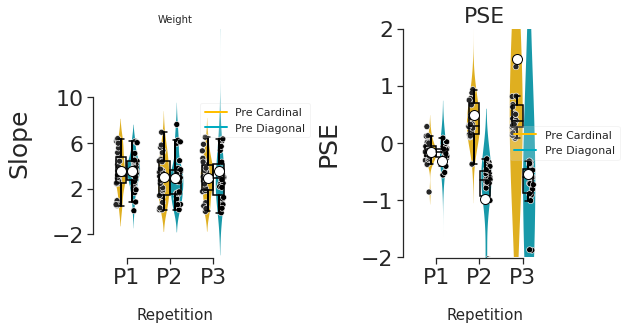

In [246]:
sns.set(style="ticks",font_scale=2)
mycol = ['#ffbf00' , '#00acc1'] 
dat = log_reg_nrep
ort = "v"; 
pal = "Set2"
dx = "nrep"; ort = "v"; pal = pal; sigma = .5
f, axes = plt.subplots(1,2,figsize=(9, 5))


dy = "weight"

dat = log_reg_preDeci.copy()

ax0 = sns.boxplot( x = dx, y = dy, data = dat, hue = "deci-1", color = 'black'
      ,width = .5, zorder = 2, showcaps = True,  showmeans=True, meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"},
      boxprops = {'facecolor':'None', "zorder":2}, showfliers=False,
      whiskerprops = {'linewidth':2, "zorder":2}, 
      saturation = 0.7, orient = ort, ax = axes[0])      

ax = sns.stripplot(x = dx, y = dy, data = dat,  hue = "deci-1", color = "black",  dodge=True,
     edgecolor = "white",size = 6, linewidth = 0.6, jitter = 1, zorder = 2,
      orient = ort, ax = axes[0])   

ax1 = sns.violinplot( x = dx, y = dy, data = dat ,  hue = "deci-1", palette = mycol, 

     bw = 0.5, cut = 2, width = .6, 
     inner = None, orient = ort, linewidth = 0, zorder = 0, ax = axes[0])


lines = [Line2D([0], [0], color=c, linewidth=2) for c in mycol]; 
ax1.legend(lines, labels, bbox_to_anchor=(0.62,0.5), fontsize=11, framealpha= 0.2)
f.tight_layout()


axes[0].set_xlim([-0.75, 3])
axes[0].set_xticks([0,1,2])
axes[0].set_xticklabels(['P1','P2','P3'])
axes[0].set_xlabel('Repetition', fontdict={'size':15}, labelpad=20); 


axes[0].set_ylim([-4, 16])
axes[0].set_yticks(np.arange(-2, 14, step=4))
axes[0].set_ylabel('Slope', fontsize = 25, labelpad=20);

axes[0].tick_params(axis='x', labelsize=22) 
axes[0].tick_params(axis='y', labelsize=22)  
axes[0].set_title('Weight',fontsize = 10)
sns.despine(offset = 1,  trim=True, ax = axes[0]);



dy = "PSE"

dat = log_reg_preDeci.copy()

ax0 = sns.boxplot( x = dx, y = dy, data = dat, hue = "deci-1", color = 'black'
      ,width = .5, zorder = 2, showcaps = True,  showmeans=True, meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"},
      boxprops = {'facecolor':'None', "zorder":2}, showfliers=False,
      whiskerprops = {'linewidth':2, "zorder":2}, 
      saturation = 0.7, orient = ort, ax = axes[1])


ax = sns.stripplot(x = dx, y = dy, data = dat,  hue = "deci-1", color = "black",  dodge=True,
     edgecolor = "white",size = 6, linewidth = 0.6, jitter = 1, zorder = 2,
      orient = ort, ax = axes[1])   

ax1 = sns.violinplot( x = dx, y = dy, data = dat ,  hue = "deci-1", palette = mycol, 

     bw = 0.5, cut = 2, width = .6, 
     inner = None, orient = ort, linewidth = 0, zorder = 0, ax = axes[1])


lines = [Line2D([0], [0], color=c, linewidth=2) for c in mycol]; 
ax1.legend(lines, labels, bbox_to_anchor=(0.62,0.5), fontsize=11, framealpha= 0.2)
f.tight_layout()

axes[1].set_xlim([-0.75, 3])
axes[1].set_xticks([0,1,2])
axes[1].set_xticklabels(['P1','P2','P3'])
axes[1].set_xlabel('Repetition', fontdict={'size':15}, labelpad=20); 


axes[1].set_ylim([-2, 2])
axes[1].set_yticks(np.arange(-2, 3, step=1))
axes[1].set_ylabel('PSE', fontsize = 25, labelpad=20);

axes[1].tick_params(axis='x', labelsize=22) 
axes[1].tick_params(axis='y', labelsize=22)  
axes[1].set_title('PSE',fontsize = 22)
sns.despine(offset = 1,  trim=True, ax = axes[1]);

Calculating the difference between deci-1 to simplify the plotting

## Analyses in not long format dataframe

In [247]:
df.columns

Index(['npar', 'subj', 'nblock', 'ntrial', 'nrep', 'cond-1', 'cond', 'rDV',
       'DV', 'resp', 'deci-2', 'deci-1', 'deci', 'corr-1', 'r_map', 'correct',
       'RT', 'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'o1', 'o2', 'o3', 'o4', 'o5',
       'o6'],
      dtype='object')

In [248]:
def log_stimmultreg_fit(x, f): # this function was used to calculate the log linear regression between two vectors
    reg = smf.glm(formula = f, data = x, family=sm.families.Binomial()).fit()
    params = reg.params
    # concatenating parametersout = pd.DataFrame({'intercept':[params[0]] , 'weight':[params[1]],'PSE': PSE})
    out = pd.DataFrame({'intercept':[params[0]] , 'G1ori':[params[1]], 'G2ori':[params[2]], 'G3ori':[params[3]], 'G4ori':[params[4]], 'G5ori':[params[5]], 'G6ori':[params[6]]})
    return out #intercept + weight

In [249]:
formula = 'deci~d1+d2+d3+d4+d5+d6'
df_mr_betas = df.groupby(['subj','nrep']).apply(log_stimmultreg_fit, formula) # probably confidence changes as the experiment progresses
df_mr_betas.reset_index(inplace = True)

In [250]:
df_betas = pd.melt(df_mr_betas, id_vars=['subj','nrep'], value_vars=['intercept', 'G1ori','G2ori','G3ori','G4ori','G5ori','G6ori'])
df_betas.rename(columns={'variable' : "parameter"}, inplace=True)
df_betas.head(4)

,subj,nrep,parameter,value
0,p02,0,intercept,0.702624
1,p02,1,intercept,0.796446
2,p02,2,intercept,0.800216
3,p03,0,intercept,0.947119


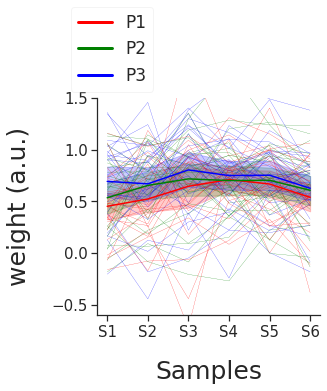

In [251]:
plt.subplots(ncols = 1, figsize = (4,4))
nrep_labels = np.unique(df.nrep) #nrep
n_par_labels = np.unique(df.subj)#npar

mycol = ["red", "green","blue"]
df_betas_plot = df_betas[df_betas.parameter != 'intercept']
for i in n_par_labels:
    dat= df_betas_plot[df_betas_plot.subj ==i]
    sns.lineplot(x="parameter", y="value", hue="nrep", 
                 palette= mycol, err_style=None,ci=95, lw=0.2, data=dat)
    plt.xlabel('Stimulus', fontsize= 13)
    plt.ylabel('Intercept', fontsize= 13)
    
    legend =plt.legend(frameon=False, title = 'Rep')
    legend.remove()    
sns.lineplot(x="parameter", y="value", hue="nrep",
             palette= mycol, data= df_betas_plot)

legend.remove()
ind = ind = np.arange(6)

plt.ylim(-0.6,1); 
plt.ylabel('weight (a.u.)', fontsize = 25, labelpad=20); 
plt.yticks(np.arange(-0.5, 1.65, step=0.5), fontsize = 15) 
plt.xlabel('Samples', fontdict={'size':25}, labelpad=20); 
plt.xticks(ind, ('S1', 'S2', 'S3', 'S4', 'S5', 'S6'), fontsize = 15)

lines = [Line2D([0], [0], color=c, linewidth=3) for c in mycol]; 
labels = ['P1', 'P2', 'P3']; 
lines = [Line2D([0], [0], color=c, linewidth=3) for c in mycol]; labels = ['P1', 'P2', 'P3']; 
plt.legend(lines, labels, bbox_to_anchor=(0.29,0.99), fontsize=17, framealpha= 0.2)

sns.despine(top=True);
#plt.savefig('sample_intercept4part.png',bbox_inches='tight')


<font size="4"> Statistical tests 

In [252]:
dat = df_betas[df_betas.parameter != 'intercept']
# ANOVA to check if there are differences at the INTERCEPT depending on the stimuli position
pg.rm_anova(dv = 'value', within = ['nrep', 'parameter'], subject = 'subj', 
            data=dat, detailed = True, correction = True)

/home/freeman/anaconda3/lib/python3.8/site-packages/pingouin/distribution.py:459: UserWarning: Epsilon values might be innaccurate in two-way repeated measures design where each  factor has more than 2 levels. Please  double-check your results.
  warnings.warn("Epsilon values might be innaccurate in "


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,nrep,1.238377,2,50,0.619189,12.229162,0.000047,0.000082,0.328483,0.923225
1,parameter,2.047374,5,125,0.409475,2.777614,0.020514,0.032114,0.099995,0.781887
2,nrep * parameter,0.439047,10,250,0.043905,1.132056,0.338561,0.346230,0.043321,0.421169


In [253]:
# ANOVA to check if there are differences at the INTERCEPT depending on the stimuli position
dat = df_betas[df_betas.parameter == 'intercept']

pg.pairwise_ttests(dv='value', within= ['nrep'], subject='subj', interaction=True, effsize = 'cohen', data=dat) 

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,cohen
0,nrep,0,1,True,True,-0.786486,25.0,two-sided,0.438975,0.275,-0.079472
1,nrep,0,2,True,True,-1.064972,25.0,two-sided,0.297067,0.345,-0.096529
2,nrep,1,2,True,True,-0.308957,25.0,two-sided,0.759914,0.217,-0.027983


<font size="3">  __Category similarity between consecutive samples__

In [254]:
# This function calculates the minimum difference in circular space between two angles
def circ_angles_diff(x,ref):
    x = np.rad2deg(x)
    ref = np.rad2deg(ref)
    diffs = x - ref
    diffs = (diffs + 180) % 360 - 180
    return diffs
#circ_angles_diff(np.array([5, 20, 30]),200)    

In [255]:
def log_stimmultreg_fit(x, f): # this function was used to calculate the log linear regression between two vectors
    reg = smf.glm(formula = f, data = x, family=sm.families.Binomial()).fit()
    params = reg.params
    # concatenating parametersout = pd.DataFrame({'intercept':[params[0]] , 'weight':[params[1]],'PSE': PSE})
    out = pd.DataFrame({'intercept':[params[0]] , 'G1ori':[params[1]], 'G2ori':[params[2]], 'G3ori':[params[3]], 'G4ori':[params[4]], 'G5ori':[params[5]]})
    return out #intercept + weight

In [256]:
# function that I used to plot multiple data
def myviolinplot(data, dx, dy, col, row, pal, size, yaxis, axislabels, sizepoint):    
    sns.set(font_scale = 1.5, style = 'ticks')         
    ort = "v"; pal = pal; sigma = .5
    g = sns.FacetGrid(data ,  row = row, col = col, height= size['height'], aspect=size['aspect'], margin_titles=True) # col="nrep",    
    if sizepoint == None:
        sizepoint = 6
    if yaxis != None:
        g.set(yaxis['ylim'], yaxis['yticks'])   

    g.map_dataframe(sns.violinplot, x = dx, y = dy,  palette = pal,bw = .5, cut = 0.,scale = "area", width = .6, inner = None, orient = ort, linewidth = 0, zorder = 2)
    g.map_dataframe(sns.stripplot, x = dx, y = dy, data = dat,  color = "black", edgecolor = "white",size = sizepoint, linewidth = 0.6, jitter = 1, orient = ort)
    g.map_dataframe(sns.boxplot, x = dx, y = dy, data = dat, color = "black", width = .15, zorder = 3, showcaps = True,  showmeans=True,meanprops={"marker":"o",
                           "markerfacecolor":"white", 
                           "markeredgecolor":"black",
                          "markersize":"10"},
          boxprops = {'facecolor':'None', "zorder":2}, showfliers=True,
          whiskerprops = {'linewidth':2, "zorder":2}, 
          saturation = 0.1, orient = ort)

    #g.map_dataframe(sns.lineplot, x = dx, y= dy,  units= "NIUB" , estimator=None, linewidth = 0.5, zorder = 1, color = 'grey')
    sns.despine(offset = .5,  trim=True);
    # Set x-axis and y-axis labels
    g.set_axis_labels( axislabels['xlabel'] , axislabels['ylabel'], fontsize = 15 )
    #g.tight_layout()


In [257]:
diff1 = circ_angles_diff(df.o2,df.o1)
diff2 = circ_angles_diff(df.o3,df.o2)
diff3 = circ_angles_diff(df.o4,df.o3)
diff4 = circ_angles_diff(df.o5,df.o4)
diff5 = circ_angles_diff(df.o6,df.o5)

prev_respdiff = np.abs(pd.concat([diff1,diff2,diff3,diff4,diff5], axis = 1))
prev_respdiff = prev_respdiff.to_numpy()

In [258]:
sort_idx = prev_respdiff.argsort(axis = 1)

In [259]:
orientations = np.matrix(df.iloc[:, 17:23])
orientations = np.take_along_axis(orientations,sort_idx, axis = 1)

In [260]:
reo_orientations = pd.DataFrame(orientations,columns=['G1sim','G2sim','G3sim','G4sim','G5sim'])
df_glm = pd.concat([df, reo_orientations],axis = 1)

In [261]:
formula = 'deci~G1sim+G2sim+G3sim+G4sim+G5sim'
#formula = 'deci~d1+d2+d3+d4+d5+d6'
df_mr_betas = df_glm.groupby(['subj']).apply(log_stimmultreg_fit, formula) # probably confidence changes as the experiment progresses
df_mr_betas.reset_index(inplace = True)

df_betas = pd.melt(df_mr_betas, id_vars=['subj'], value_vars=['intercept', 'G1ori','G2ori','G3ori','G4ori','G5ori',])
df_betas.rename(columns={'variable' : "parameter"}, inplace=True)
#df_betas.head(4)

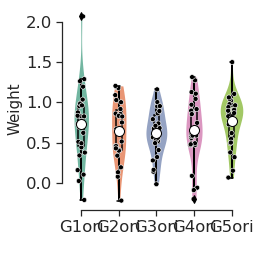

In [262]:
sizeplot = {}; sizeplot['height'] = 4; sizeplot['aspect'] = 1
axislabels = {}; axislabels['xlabel'] = ' '; axislabels['ylabel']= 'Weight'
yaxis = None # yaxis = {}; yaxis['ylim']=[-2,4], yaxis['yticks']=[-2, 0, 2, 4]

dx = 'parameter'; dy = 'value'; col = None; row = None
pal = "Set2"
# & (~df_betas.NIUB.isin(out_subjs))
myviolinplot(df_betas[(df_betas.parameter != 'intercept') ], dx, dy, col, row, pal, sizeplot, yaxis, axislabels, sizepoint = 5)

In [263]:
dat = df_betas[ (df_betas.parameter != 'intercept')] 
#dat = dat[~dat.NIUB.isin(out_subjs)]
#dat = dat[dat.NIUB.isin(in_subjs)]
aov = AnovaRM(dat, 'value', 'subj', within=['parameter'])
resaov = aov.fit()
print(resaov) 

                 Anova
          F Value Num DF  Den DF  Pr > F
----------------------------------------
parameter  1.2709 4.0000 100.0000 0.2865



In [266]:
# ANOVA to check if there are differences at the INTERCEPT depending on the stimuli position
dat = df_betas[df_betas.parameter == 'intercept']

pg.pairwise_ttests(dv='value', within= ['nrep'], subject='subj', interaction=True, effsize = 'cohen', data=dat) 

AssertionError: 

In [267]:
diff1 = df.d2 - df.d1
diff2 = df.d3 - df.d2
diff3 = df.d4 - df.d3
diff4 = df.d5 - df.d4
diff5 = df.d6 - df.d5

prev_respdiff = np.abs(pd.concat([diff1,diff2,diff3,diff4,diff5], axis = 1))
prev_respdiff = prev_respdiff.to_numpy()
#plt.hist(prev_respdiff)

In [268]:
sort_idx = prev_respdiff.argsort(axis = 1)

In [269]:
orientations = np.matrix(df.iloc[:, 17:23])
orientations = np.take_along_axis(orientations,sort_idx, axis = 1)

In [270]:
reo_orientations = pd.DataFrame(orientations,columns=['G1sim','G2sim','G3sim','G4sim','G5sim'])
df_glm = pd.concat([df, reo_orientations],axis = 1)

In [271]:
formula = 'deci~G1sim+G2sim+G3sim+G4sim+G5sim'
#formula = 'deci~d1+d2+d3+d4+d5+d6'
df_mr_betas = df_glm.groupby(['subj']).apply(log_stimmultreg_fit, formula) # probably confidence changes as the experiment progresses
df_mr_betas.reset_index(inplace = True)

df_betas = pd.melt(df_mr_betas, id_vars=['subj'], value_vars=['intercept', 'G1ori','G2ori','G3ori','G4ori','G5ori',])
df_betas.rename(columns={'variable' : "parameter"}, inplace=True)
#df_betas.head(4)

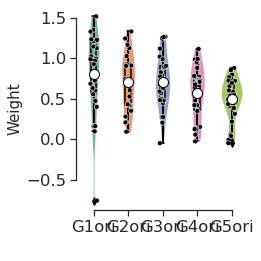

In [272]:
sizeplot = {}; sizeplot['height'] = 4; sizeplot['aspect'] = 1
axislabels = {}; axislabels['xlabel'] = ' '; axislabels['ylabel']= 'Weight'
yaxis = None # yaxis = {}; yaxis['ylim']=[-2,4], yaxis['yticks']=[-2, 0, 2, 4]

dx = 'parameter'; dy = 'value'; col = None; row = None
pal = "Set2"
# & (~df_betas.NIUB.isin(out_subjs))
myviolinplot(df_betas[(df_betas.parameter != 'intercept') ], dx, dy, col, row, pal, sizeplot, yaxis, axislabels, sizepoint = 5)

In [273]:
dat = df_betas[ (df_betas.parameter != 'intercept')] 
#dat = dat[~dat.NIUB.isin(out_subjs)]
#dat = dat[dat.NIUB.isin(in_subjs)]
aov = AnovaRM(dat, 'value', 'subj', within=['parameter'])
resaov = aov.fit()
print(resaov) 

                 Anova
          F Value Num DF  Den DF  Pr > F
----------------------------------------
parameter  5.1394 4.0000 100.0000 0.0008



In [274]:
def log6_stimmultreg_fit(x, f): # this function was used to calculate the log linear regression between two vectors
    reg = smf.glm(formula = f, data = x, family=sm.families.Binomial()).fit()
    params = reg.params
    # concatenating parametersout = pd.DataFrame({'intercept':[params[0]] , 'weight':[params[1]],'PSE': PSE})
    out = pd.DataFrame({'intercept':[params[0]] , 'G1ori':[params[1]], 'G2ori':[params[2]], 'G3ori':[params[3]], 'G4ori':[params[4]], 'G5ori':[params[5]], 'G6ori':[params[6]]})
    return out #intercept + weight

In [275]:
prev_deci =  df['deci-1'].astype( 'int64')
prev_deci[prev_deci == 0] = -1

In [276]:
diff1 = df.d1 -  prev_deci
diff2 = df.d2 -  prev_deci
diff3 = df.d3 -  prev_deci
diff4 = df.d4 -  prev_deci
diff5 = df.d5 -  prev_deci
diff6 = df.d6 -  prev_deci

prev_respdiff = np.abs(pd.concat([diff1,diff2,diff3,diff4,diff5,diff6], axis = 1))
prev_respdiff = prev_respdiff.to_numpy()
#plt.hist(prev_respdiff)
sort_idx = prev_respdiff.argsort(axis = 1)
prev_respdiff = np.take_along_axis(prev_respdiff,sort_idx, axis = 1)

In [277]:
orientations = np.matrix(df.iloc[:, 17:23])
orientations = np.take_along_axis(orientations,sort_idx, axis = 1)
reo_orientations = pd.DataFrame(orientations,columns=['G1sim','G2sim','G3sim','G4sim','G5sim','G6sim'])
df_glm = pd.concat([df, reo_orientations],axis = 1)

In [278]:
 isub

'p30'

In [279]:
subjs = np.unique(df_glm.subj)
select_mask = np.array(['s22']) #prevcat
mask = np.isin(subjs, select_mask, invert=True)
formula = 'deci~G1sim+G2sim+G3sim+G4sim+G5sim+G6sim'
for idx, isub in enumerate(subjs[mask]): #isub in subjs:z
    df_subj =df_glm[df_glm.subj == isub] # s16 does not converge
    df_subj.groupby(['subj','nrep']).apply(log6_stimmultreg_fit, formula) # probably confidence changes as the experiment progresses

    #ldf_mr_betas['NIUB'] = isub
    #if idx == 0:
    #    df_mr_betas = pd.DataFrame(columns=ldf_mr_betas.columns)
        
    #df_mr_betas = pd.concat([df_mr_betas, ldf_mr_betas])
    

In [280]:
formula = 'deci~G1sim+G2sim+G3sim+G4sim+G5sim+G6sim'
#formula = 'deci~d1+d2+d3+d4+d5+d6'
#df_glm = df_glm[df_glm.subj != 's22']
df_mr_betas = df_glm.groupby(['subj','nrep']).apply(log6_stimmultreg_fit, formula) # probably confidence changes as the experiment progresses
df_mr_betas.reset_index(inplace = True)

df_betas = pd.melt(df_mr_betas, id_vars=['subj', 'nrep'], value_vars=['intercept', 'G1ori','G2ori','G3ori','G4ori','G5ori','G6ori'])
df_betas.rename(columns={'variable' : "parameter"}, inplace=True)
#df_betas.head(4)

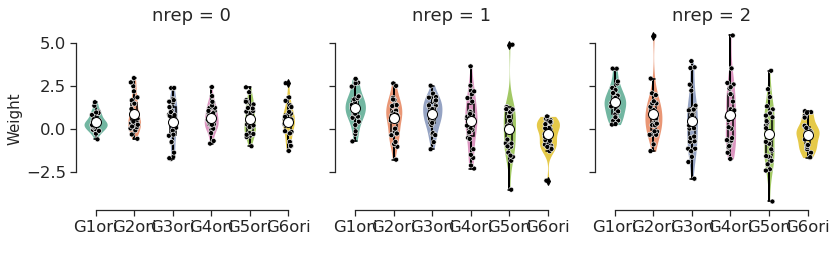

In [281]:
sizeplot = {}; sizeplot['height'] = 4; sizeplot['aspect'] = 1
axislabels = {}; axislabels['xlabel'] = ' '; axislabels['ylabel']= 'Weight'
yaxis = None # yaxis = {}; yaxis['ylim']=[-2,4], yaxis['yticks']=[-2, 0, 2, 4]

dx = 'parameter'; dy = 'value'; col = 'nrep'; row = None
pal = "Set2"
# & (~df_betas.NIUB.isin(out_subjs))
myviolinplot(df_betas[(df_betas.parameter != 'intercept') ], dx, dy, col, row, pal, sizeplot, yaxis, axislabels, sizepoint = 5)

In [282]:
dat = df_betas[ (df_betas.parameter != 'intercept')] 
#dat = dat[~dat.NIUB.isin(out_subjs)]
#dat = dat[dat.NIUB.isin(in_subjs)]
aov = AnovaRM(dat, 'value', 'subj', within=['parameter','nrep'])
resaov = aov.fit()
print(resaov) 

                    Anova
               F Value  Num DF  Den DF  Pr > F
----------------------------------------------
parameter       8.2274  5.0000 125.0000 0.0000
nrep            2.9791  2.0000  50.0000 0.0599
parameter:nrep  2.8492 10.0000 250.0000 0.0022



In [283]:
dat = df_betas[ (df_betas.parameter != 'intercept') & (df_betas.nrep == 2)] 
#dat = dat[~dat.NIUB.isin(out_subjs)]
#dat = dat[dat.NIUB.isin(in_subjs)]
aov = AnovaRM(dat, 'value', 'subj', within=['parameter'])
resaov = aov.fit()
print(resaov) 

                 Anova
          F Value Num DF  Den DF  Pr > F
----------------------------------------
parameter  5.9564 5.0000 125.0000 0.0001



In [ ]:
CONFIDENCE HOW DOES INTERACT WITH THIS?
ENTER IN SIMULATIONS
REANALIZE THE FIRST EXPERIMENT IN THIS WAY

SyntaxError: invalid syntax (1153594875.py, line 2)

In [549]:
# ANOVA to check if there are differences at the INTERCEPT depending on the stimuli position
dat = df_betas[(df_betas.parameter != 'intercept') & (df_betas.nrep == 1)& (df_betas.blocktype == 'repeat')]

pg.pairwise_ttests(dv='value', within= ['parameter'], subject='subj', interaction=True, effsize = 'cohen', data=dat) 

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,cohen
0,parameter,G1ori,G2ori,True,True,1.179649,26.0,two-sided,0.248822,0.381,0.408606
1,parameter,G1ori,G3ori,True,True,1.296611,26.0,two-sided,0.206155,0.432,0.364109
2,parameter,G1ori,G4ori,True,True,1.418442,26.0,two-sided,0.167938,0.499,0.296676
3,parameter,G1ori,G5ori,True,True,1.120237,26.0,two-sided,0.272854,0.359,0.324175
4,parameter,G1ori,G6ori,True,True,5.533273,26.0,two-sided,0.000008,2547.616,1.388492
5,parameter,G2ori,G3ori,True,True,-0.261389,26.0,two-sided,0.795852,0.21,-0.087328
6,parameter,G2ori,G4ori,True,True,-0.452043,26.0,two-sided,0.654987,0.224,-0.134113
7,parameter,G2ori,G5ori,True,True,-0.399827,26.0,two-sided,0.692550,0.219,-0.097921
8,parameter,G2ori,G6ori,True,True,2.712126,26.0,two-sided,0.011694,4.087,0.699639
9,parameter,G3ori,G4ori,True,True,-0.176703,26.0,two-sided,0.861111,0.207,-0.054525


In [541]:
dat = df_betas[ (df_betas.parameter != 'intercept') &  (df_betas.nrep == 0)] 
#dat = dat[~dat.NIUB.isin(out_subjs)]
#dat = dat[dat.NIUB.isin(in_subjs)]
aov = AnovaRM(dat, 'value', 'subj', within=['parameter','blocktype'])
resaov = aov.fit()
print(resaov) 

                      Anova
                    F Value Num DF  Den DF  Pr > F
--------------------------------------------------
parameter            3.4944 5.0000 130.0000 0.0054
blocktype            2.1920 1.0000  26.0000 0.1507
parameter:blocktype  0.9036 5.0000 130.0000 0.4810



In [480]:
dat = df_betas[ (df_betas.parameter == 'intercept')] 
#dat = dat[~dat.NIUB.isin(out_subjs)]
#dat = dat[dat.NIUB.isin(in_subjs)]
aov = AnovaRM(dat, 'value', 'subj', within=['nrep','blocktype'])
resaov = aov.fit()
print(resaov) 

                   Anova
               F Value Num DF  Den DF Pr > F
--------------------------------------------
nrep            0.1749 1.0000 26.0000 0.6792
blocktype       0.9443 1.0000 26.0000 0.3401
nrep:blocktype  2.5841 1.0000 26.0000 0.1200



In [475]:
dat = df_betas[ (df_betas.parameter != 'intercept') &  (df_betas.nrep == 1)] 
#dat = dat[~dat.NIUB.isin(out_subjs)]
#dat = dat[dat.NIUB.isin(in_subjs)]
aov = AnovaRM(dat, 'value', 'subj', within=['parameter','blocktype'])
resaov = aov.fit()
print(resaov) 

                      Anova
                    F Value Num DF  Den DF  Pr > F
--------------------------------------------------
parameter            4.2945 5.0000 130.0000 0.0012
blocktype            3.2164 1.0000  26.0000 0.0845
parameter:blocktype  1.2830 5.0000 130.0000 0.2751



In [ ]:
sizeplot = {}; sizeplot['height'] = 4; sizeplot['aspect'] = 1
axislabels = {}; axislabels['xlabel'] = ' '; axislabels['ylabel']= 'Weight'
yaxis = None # yaxis = {}; yaxis['ylim']=[-2,4], yaxis['yticks']=[-2, 0, 2, 4]

dx = 'parameter'; dy = 'value'; col = 'nrep'; row = None
pal = "Set2"
# & (~df_betas.NIUB.isin(out_subjs))
myviolinplot(df_betas[(df_betas.parameter != 'intercept') ], dx, dy, col, row, pal, sizeplot, yaxis, axislabels, sizepoint = 5)

<font size="4"> Statistical tests for Inercept

<font size="2"> _There were non statisitcal differences in sample position and intercept._

<font size="5"> _Figure 5 A & B. Category similarity between consecutive samples._

Logisitc regression model with the category of the previous stimuli sample

In [ ]:
# First, build a logistic model with presentations and the category of previous sample

dflong_seq_clean = dflong_seq[(dflong_seq.subj != 's16') & (dflong_seq.subj != 's22') &  (dflong_seq.subj != 's10')]

formula = "deci ~ dv"

log_regpre_deci_params = dflong_seq_clean.groupby(['subj', 'cong_stim_DV','cong_stim_OV']).apply(log_reg_fit, formula)
log_regpre_deci_params.reset_index(inplace = True)
log_regpre_deci_params.head()

In [ ]:
#%matplotlib inline
sns.set(font_scale = 1.5, style = 'ticks') 
dat = log_regpre_deci_params

ort = "v"; 
pal = "Set2"
# define variables to plot
dx = "cong_stim_OV"; dy = "weight"; ort = "v"; pal = pal; sigma = .5

g = sns.FacetGrid(dat , col = 'cong_stim_DV',  height= 3.5, aspect=.95,margin_titles=True) # col="nrep",
g.set(ylim=[-1.5,3], yticks=[-1, 0, 1, 2, 3])
#g.tight_layout()

g.map_dataframe(sns.lineplot, x = dx, y= dy,  units= "subj" , estimator=None, linewidth = 0.5, zorder = 1, color = 'grey')
g.map_dataframe(sns.violinplot, x = dx, y = dy,  palette = pal,bw = .5, cut = 0.,scale = "area", width = .6, inner = None, orient = ort, linewidth = 0, zorder = 2)
g.map_dataframe(sns.stripplot, x = dx, y = dy, data = dat,  color = "black", edgecolor = "white",size = 6, linewidth = 0.6, jitter = 1, orient = ort)
g.map_dataframe(sns.boxplot, x = dx, y = dy, data = dat, color = "black", width = .15, zorder = 3, showcaps = True,  showmeans=True,meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"},
      boxprops = {'facecolor':'None', "zorder":2}, showfliers=True,
      whiskerprops = {'linewidth':2, "zorder":2}, 
      saturation = 0.1, orient = ort)


#g.map_dataframe(sns.lineplot,x = dx, y= dy, data=dat, units= "subj" , estimator=None, color = 'grey',linewidth = 0.5)
sns.despine(offset = .5,  trim=True);
axes = g.axes.flatten()
#axes[0].set_title("P1",fontsize = 20);axes[1].set_title("P2",fontsize = 20);axes[2].set_title("P3",fontsize = 20)
#axes[3].set_title("",fontsize = 20);axes[4].set_title("",fontsize = 20);axes[5].set_title("",fontsize = 20)

#g._margin_titles_texts[0].set_color("red")
#g._margin_titles_texts[0].set_text("Cardinal")
#g._margin_titles_texts[0].set_size("20")
#g._margin_titles_texts[1].set_text("Diagonal")
#g._margin_titles_texts[1].set_size("20")

#g.fig.subplots_adjust( top = -.85 )
  
# Set x-axis and y-axis labels
g.set_axis_labels( "" , "Weight (a.u.)", fontsize = 15 )
#g.tight_layout()


<font size="4"> Statistical tests for Beta Weight

In [ ]:
#Checking statistical differences in Weight between the number of repetitions & the previous sample category
# If there are differences after adreesing the ANOVA, the differences that we saw at the plot are significant

pg.rm_anova(dv = 'weight', within = ['cong_stim_DV','cong_stim_OV'], subject = 'subj', 
            data=log_regpre_deci_params, detailed = True, correction = True)

#Weight was larger in those samples that followed a sample from the same category

Post-hoc t-test

In [ ]:
#post-hoc t-test
pg.pairwise_ttests(dv='weight', within=['cong_stim_DV','nrep'], subject='npar', 
                   padjust='bonf', effsize = 'cohen',interaction=False, data=log_regpre_deci_params) 

In [ ]:
# post-hoc t-test for P1
dat = log_regpre_deci_params.loc[log_regpre_deci_params.nrep == 0] 
pg.pairwise_ttests(dv='weight', within=['cong_stim_DV'], subject='npar', padjust='bonf', effsize = 'cohen', data=dat)

In [ ]:
# post-hoc t-test for P2
dat = log_regpre_deci_params.loc[log_regpre_deci_params.nrep == 1] 
pg.pairwise_ttests(dv='weight', within=['cong_stim_DV'], subject='npar', padjust='bonf', effsize = 'cohen', data=dat)

In [ ]:
# post-hoc t-test for P3
dat = log_regpre_deci_params.loc[log_regpre_deci_params.nrep == 2] 
pg.pairwise_ttests(dv='weight', within=['cong_stim_DV'], subject='npar', padjust='bonf', effsize = 'cohen', data=dat)

<font size="5"> _5B. Intercept._

In [ ]:
#%matplotlib inline
sns.set(font_scale = 1.5, style = 'ticks') 
dat = log_regpre_deci_params

ort = "v"; 
pal = "Set2"
# define variables to plot
dx = "cong_stim_OV"; dy = "intercept"; ort = "v"; pal = pal; sigma = .5

g = sns.FacetGrid(dat , col = 'cong_stim_DV',  height= 3.5, aspect=.95,margin_titles=True) # col="nrep",
g.set(ylim=[-1.5,3], yticks=[-1, 0, 1, 2, 3])
#g.tight_layout()

g.map_dataframe(sns.lineplot, x = dx, y= dy,  units= "subj" , estimator=None, linewidth = 0.5, zorder = 1, color = 'grey')
g.map_dataframe(sns.violinplot, x = dx, y = dy,  palette = pal,bw = .5, cut = 0.,scale = "area", width = .6, inner = None, orient = ort, linewidth = 0, zorder = 2)
g.map_dataframe(sns.stripplot, x = dx, y = dy, data = dat,  color = "black", edgecolor = "white",size = 6, linewidth = 0.6, jitter = 1, orient = ort)
g.map_dataframe(sns.boxplot, x = dx, y = dy, data = dat, color = "black", width = .15, zorder = 3, showcaps = True,  showmeans=True,meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"},
      boxprops = {'facecolor':'None', "zorder":2}, showfliers=True,
      whiskerprops = {'linewidth':2, "zorder":2}, 
      saturation = 0.1, orient = ort)


#g.map_dataframe(sns.lineplot,x = dx, y= dy, data=dat, units= "subj" , estimator=None, color = 'grey',linewidth = 0.5)
sns.despine(offset = .5,  trim=True);
axes = g.axes.flatten()
#axes[0].set_title("P1",fontsize = 20);axes[1].set_title("P2",fontsize = 20);axes[2].set_title("P3",fontsize = 20)
#axes[3].set_title("",fontsize = 20);axes[4].set_title("",fontsize = 20);axes[5].set_title("",fontsize = 20)

#g._margin_titles_texts[0].set_color("red")
#g._margin_titles_texts[0].set_text("Cardinal")
#g._margin_titles_texts[0].set_size("20")
#g._margin_titles_texts[1].set_text("Diagonal")
#g._margin_titles_texts[1].set_size("20")

#g.fig.subplots_adjust( top = -.85 )
  
# Set x-axis and y-axis labels
g.set_axis_labels( "" , "Intercept (a.u.)", fontsize = 15 )
#g.tight_layout()


<font size="4"> Statistical tests for Inercept

In [ ]:
#Checking statistical differences in Intercept between the number of repetitions 
# & the orientation of the previous stimulus

pg.rm_anova(dv = 'intercept', within = ['nrep', 'pre_stim'], subject = 'npar', 
            data=log_regpre_deci_params, detailed = True, correction = True)

# no differences in the intercept

In [ ]:
pg.pairwise_ttests(dv='intercept', within=['pre_stim', 'nrep'], subject='npar', 
                   padjust='bonf', effsize = 'cohen', data=log_regpre_deci_params) 

In [ ]:
# post-hoc t-test for P1

dat= log_regpre_deci_params.loc[log_regpre_deci_params.nrep==0]
pg.pairwise_ttests(dv='intercept', within=['pre_stim'], subject='npar', 
                   padjust='bonf', effsize = 'cohen', data=dat) 

In [ ]:
# post-hoc t-test for P2

dat= log_regpre_deci_params.loc[log_regpre_deci_params.nrep==1]
pg.pairwise_ttests(dv='intercept', within=['pre_stim'], subject='npar', 
                   padjust='bonf', effsize = 'cohen', data=dat) 

In [ ]:
# post-hoc t-test for P3

dat= log_regpre_deci_params.loc[log_regpre_deci_params.nrep==2]
pg.pairwise_ttests(dv='intercept', within=['pre_stim'], subject='npar', 
                   padjust='bonf', effsize = 'cohen', data=dat) 

<font size="5"> _Figure 5 C & D. Physical similarity between consecutive samples._

<font size="5"> _5C. Beta Weight._

Logisitc regression model with the physical similarity with previous sample

In [ ]:
formula = "deci ~ dv"

log_regpre_orient_params = dflong_seq.groupby(['npar', 'nrep', 'cong_stim_OV']).apply(log_reg_fit, formula)
log_regpre_orient_params.reset_index(inplace = True)
log_regpre_orient_params.head()

In [ ]:
# Stimulus following one similar orientated (do not differ in many degrees) are weighted less than others
# preceded by stimuli from distant orientations.

fig = go.Figure()
data = log_regpre_orient_params

dat = log_regpre_orient_params.loc[(log_regpre_orient_params['cong_stim_OV'] == 0),:]
fig.add_trace(go.Box( #boxplot for the condition were one stimuli is followed by another similar oriented
    y=dat['weight'], x=dat['nrep'], boxpoints='all',
    jitter=0.99, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(color='#3FBFAA', size=11, opacity=0.6, line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Congruent', # Stimuli followed by another similar in orientation
    marker_color='#7185bd'))

dat = log_regpre_orient_params.loc[(log_regpre_orient_params['cong_stim_OV'] == 1),:]
fig.add_trace(go.Box( #condition for samples that follow stimuli pysichaly similar
    y=dat['weight'], x=dat['nrep'], boxpoints='all', pointpos=0, jitter=0.99,
    whiskerwidth=0.9,
    marker=dict(color='#9F68E3', size=11, opacity=0.6, line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15, 
    name='Incongruent', # Stimuli followed by another very different in orientation
    marker_color='#b23354'))

fig.update_layout(boxmode='group',)
fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_xaxes(showline=False, linewidth=1.5, linecolor='#696969')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#696969',
                 tickfont=dict(family='Balto, sans-serif', color='#000000', size=16))
fig.update_xaxes(tickvals = [0, 1, 2], ticktext=['P1', 'P2', 'P3'], 
                 tickangle=0, tickfont=dict(family='Balto, sans-serif', color='#424242', size=16))
fig.update_yaxes(tickvals= [0, .5, 1, 1.50, 2], ticktext=['0', '0.5', '1', '1.50', '2'])
fig.update_yaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)
fig.update_xaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)

fig.update_yaxes(showgrid=False)
fig.update_layout(
    yaxis_title="Beta weight (a.u.)",
    font=dict(family="Balto, sans-serif", size=15, color= "#424242"))

fig.update_layout(
    legend=dict(traceorder="normal", font=dict(family="Balto, sans-serif",size=13,color="#424242")))

fig['layout']['yaxis'].update(range=[-.005, 2.005])

fig.update_yaxes(zeroline=False, zerolinewidth=0, zerolinecolor='Black')
fig.add_shape(type="line", xref="x", yref="y", x0=-0.5, y0=0, x1=2.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))

fig.show()

<font size="4"> Statistical tests for Beta Weight

In [ ]:
# Checking statistical differences in 
# Weight between the number of repetitions & the orientation of the previous stimulus

pg.rm_anova(dv = 'weight', within = ['nrep', 'cong_stim_OV'], subject = 'npar', 
            data=log_regpre_orient_params, detailed = True, correction = True)

In [ ]:
#post-hoc t-test
pg.pairwise_ttests(dv='weight', within=['nrep', 'pre_orient'], subject='npar', padjust='bonf', 
                   effsize = 'cohen',interaction=False, data=log_regpre_orient_params) 

Post-hoc t-test to look for interactions within categories

In [ ]:
# post-hoc t-test for P1

dat = log_regpre_orient_params.loc[log_regpre_orient_params.nrep == 0]
pg.pairwise_ttests(dv='weight', within=['pre_orient'], subject='npar', padjust='bonf', 
                   effsize = 'cohen',interaction=False, data=dat) 

In [ ]:
# post-hoc t-test for P2

dat = log_regpre_orient_params.loc[log_regpre_orient_params.nrep == 1]
pg.pairwise_ttests(dv='weight', within=['pre_orient'], subject='npar', padjust='bonf', 
                   effsize = 'cohen',interaction=False, data=dat) 

In [ ]:
# post-hoc t-test for P3

dat = log_regpre_orient_params.loc[log_regpre_orient_params.nrep == 2]
pg.pairwise_ttests(dv='weight', within=['pre_orient'], subject='npar', padjust='bonf', 
                   effsize = 'cohen',interaction=False, data=dat) 

<font size="5"> _5D. Intercept._

In [ ]:
fig = go.Figure()

data = log_regpre_orient_params
dat = log_regpre_orient_params.loc[(log_regpre_orient_params.pre_orient == 0),:]

fig.add_trace(go.Box(
    y=dat['intercept'], x=dat['nrep'], boxpoints='all',
    jitter=0.99, # add some jitter for a better separation between points
    pointpos=0,
        marker=dict(color='#3FBFAA',size=11,opacity=0.6,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Congruent', # Stimuli followed by another pyshically similar
    marker_color='#7185bd'))

dat = log_regpre_orient_params.loc[(log_regpre_orient_params.pre_orient == 1),:]
fig.add_trace(go.Box(
    y=dat['intercept'], x=dat['nrep'], boxpoints='all', pointpos=0, jitter=0.99,
    whiskerwidth=0.9,
    marker=dict(
        color='#9F68E3', size=11, opacity=0.6, line=dict(color='#f2f2f2', width=.4) ),
    notched=True, notchwidth=0.15, 
    name='Incongruent', # Stimuli followed by another very different in orientation
    marker_color='#b23354'))

fig.update_layout(boxmode='group',)
fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_xaxes(showline=False, linewidth=1.5, linecolor='#696969')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#696969',
                 tickfont=dict(family='Balto, sans-serif', color='#000000', size=16))

fig.update_xaxes(tickvals = [0, 1, 2], ticktext=['P1', 'P2', 'P3'], 
                 tickangle=0, tickfont=dict(family='Balto, sans-serif', color='#424242', size=16))
fig.update_yaxes(tickvals= [-.40, 0.50, 1.4, 0], ticktext=['-0.40', '0.50', '1.40', '0', '0.80' ,'1.20', '1.40'])
fig.update_yaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)
fig.update_xaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)

fig.update_yaxes(showgrid=False)
fig.update_layout(
    yaxis_title="Intercept (a.u.)",
    font=dict(family="Balto, sans-serif",size=15, color= "#424242"))

fig.update_layout(
    legend=dict(traceorder="normal", font=dict(family="Balto, sans-serif",size=13,color="#424242")))

fig['layout']['yaxis'].update(range=[-.405, 1.405])
fig.update_yaxes(zeroline=False, zerolinewidth=0, zerolinecolor='Black')
fig.add_shape(type="line", xref="x", yref="y", x0=-0.5, y0=0, x1=2.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))

fig.show()

<font size="4"> Statistical tests for Intercept

In [ ]:
#statistical test in Weight between the number of repetitions & the orientation of the previous stimulus

pg.rm_anova(dv = 'intercept', within = ['nrep', 'pre_orient'], subject = 'npar', 
            data=log_regpre_orient_params, detailed = True, correction = True)

<font size="5"> _Supplementary Figure 1A. Beta Weight for physical similarity between stimuli samples and previous decisions._

Logisitc regression model with congruency with stimuli sample by each presentation

In [ ]:
dflong.head()

In [ ]:
np.unique(dflong.subj)

In [ ]:
sj

In [ ]:
formula = "deci ~ dv"
for sj in np.unique(dflong.subj):
    dat = dflong[dflong.subj == sj]
    log_reg_cong_stim = dat.groupby(['nrep', 'cong_deci', 'stim_cond','blocktype']).apply(log_reg_fit, formula) 
    log_reg_cong_stim.reset_index(inplace = True)
#    log_reg_cong_stim.head(5)

In [ ]:
isubj

In [ ]:
formula = "deci ~ dv"

subjs = np.array(['s01', 's02', 's03', 's04', 's06', 's07', 's08', 's09',
      's11','s12', 's13', 's14', 's15', 's17', 's19', 's20',
       's21', 's23', 's24', 's25'])

for isubj in subjs:
    df_subj = dflong[( dflong.subj == isubj) ] # s16 does not converge
    log_reg_preDeci = df_subj.groupby(['nrep', 'cong_deci', 'stim_cond', 'blocktype']).apply(log_reg_fit, formula) 
    

In [ ]:
df_subj = dflong[(dflong.subj != 's05') & (dflong.subj != 's16') & (dflong.subj != 's22') & (dflong.subj != 's10')] # s16 does not converge
formula = "deci ~ dv"
log_reg_cong_stim = df_subj.groupby(['subj','nrep', 'cong_deci', 'stim_cond']).apply(log_reg_fit, formula) 
log_reg_cong_stim.reset_index(inplace = True)
log_reg_cong_stim.head(5)

In [ ]:
#%matplotlib inline
sns.set(font_scale = 1.5, style = 'ticks') 
#dat = log_reg_cong_stim[ (log_reg_cong_stim.blocktype=='repeat')]
dat = log_reg_cong_stim #[ (log_reg_cong_stim['conf_lvl-1']=='H')]
#dat = log_reg_cong_stim[ (log_reg_cong_stim.nrep==1)]
#dat =  log_reg_cong_stim
ort = "v"; 
pal = "Set2"
# define variables to plot
dx = "cong_deci"; dy = "weight"; ort = "v"; pal = pal; sigma = .5

g = sns.FacetGrid(dat , col = 'nrep',  row= 'stim_cond', height= 3.5, aspect=.95,margin_titles=True) # col="nrep",
g.set(ylim=[-2,4], yticks=[-2, 0, 2, 4])
#g.tight_layout()

g.map_dataframe(sns.lineplot, x = dx, y= dy,  units= "subj" , estimator=None, linewidth = 0.5, zorder = 1, color = 'grey')
g.map_dataframe(sns.violinplot, x = dx, y = dy,  palette = pal,bw = .5, cut = 0.,scale = "area", width = .6, inner = None, orient = ort, linewidth = 0, zorder = 2)
g.map_dataframe(sns.stripplot, x = dx, y = dy, data = dat,  color = "black", edgecolor = "white",size = 6, linewidth = 0.6, jitter = 1, orient = ort)
g.map_dataframe(sns.boxplot, x = dx, y = dy, data = dat, color = "black", width = .15, zorder = 3, showcaps = True,  showmeans=True,meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"},
      boxprops = {'facecolor':'None', "zorder":2}, showfliers=True,
      whiskerprops = {'linewidth':2, "zorder":2}, 
      saturation = 0.1, orient = ort)


#g.map_dataframe(sns.lineplot,x = dx, y= dy, data=dat, units= "subj" , estimator=None, color = 'grey',linewidth = 0.5)
sns.despine(offset = .5,  trim=True);
axes = g.axes.flatten()
#axes[0].set_title("P1",fontsize = 20);axes[1].set_title("P2",fontsize = 20);axes[2].set_title("P3",fontsize = 20)
#axes[3].set_title("",fontsize = 20);axes[4].set_title("",fontsize = 20);axes[5].set_title("",fontsize = 20)

#g._margin_titles_texts[0].set_color("red")
g._margin_titles_texts[0].set_text("Cardinal")
g._margin_titles_texts[0].set_size("20")
g._margin_titles_texts[1].set_text("Diagonal")
g._margin_titles_texts[1].set_size("20")

#g.fig.subplots_adjust( top = -.85 )
  
# Set x-axis and y-axis labels
g.set_axis_labels( "" , "Weight (a.u.)", fontsize = 15 )
#g.tight_layout()


'''
# you can access different features of the plot nad panels using for loops
for (row_val, col_val), ax in g.axes_dict.items():
    if row_val == "Lunch" and col_val == "Female":
        ax.set_facecolor(".95")
    else:
        ax.set_facecolor((0, 0, 0, 0))
#g.savefig("facet_plot.png")
'''

In [ ]:
log_cong_scat = log_reg_cong_stim[ (log_reg_cong_stim.cong_deci == 'C')]
log_cong_scat.reset_index(inplace = True, drop = True)
inc = log_reg_cong_stim[ (log_reg_cong_stim.cong_deci == 'I')].iloc[:,6:9]
inc.reset_index(inplace=True, drop=True)
inc.columns = ['intercept_i', 'weight_i', 'PSE_i']
log_cong_scat = pd.concat([log_cong_scat, inc], axis = 1)
# renaming by index
new_names = ['intercept_c', 'weight_c', 'PSE_c']
old_names = log_cong_scat.columns[[6,7,8]]
log_cong_scat.rename(columns=dict(zip(old_names, new_names)), inplace=True)

In [ ]:
log_cong_scat_avg = log_cong_scat.groupby(['nrep','stim_cond', 'blocktype'],as_index=False)[['weight_i','weight_c']].mean()
log_cong_scat_se = log_cong_scat.groupby(['nrep','stim_cond', 'blocktype'],as_index=False)[['weight_i','weight_c']].sem()
log_cong_scat_avg['semi'] = log_cong_scat_se.weight_i
log_cong_scat_avg['semc'] = log_cong_scat_se.weight_c


In [ ]:
datse

In [ ]:
#%matplotlib inline
mycol = ['#ffbf00' , '#00acc1'] 
sns.set(font_scale = 1.5, style = 'ticks') 
dat =log_reg_cong_stim[ (log_reg_cong_stim.nrep == 1)& (log_reg_cong_stim['conf_lvl-1'] =='L')]
#dat = log_reg_cong_stim[ (log_reg_cong_stim.nrep==0)& (log_reg_cong_stim.blocktype=='nonrepeat')]
#dat =  log_reg_cong_stim
ort = "v"; 
pal = "Set2"
# define variables to plot
dx = "weight_c"; dy = "weight_i"; ort = "v"; pal = pal; sigma = .5

g = sns.relplot(
    data=dat, kind='scatter', hue ='stim_cond',
    col='nrep', row='blocktype', x=dx, y=dy, units='subj',
    estimator=None, s = 30, height= 3.5, aspect=.95, alpha = 0.5)

def const_line(*args, **kwargs):
    x = np.arange(-2, 6, 2)
    y = x
    plt.plot(y, x,  ':', linewidth=2, color='grey', alpha = 0.5)

g.map(const_line, zorder = 4)
g.set(ylim=[-2,4], yticks=[-2, 0, 2, 4])
g.set(xlim=[-2,4], xticks=[-2, 0, 2, 4])
#sns.despine(offset = .5,  trim=True);
g.set_titles("")
g.fig.suptitle('Weights congruency')


# extract and flatten the axes from the figure
#axes = g.axes.flatten()

# iterate through each axes
for j in [0,1]: #for loop to compute the average by each participant
    for z in [0,1]:
        data = log_cong_scat_avg[(log_cong_scat_avg.blocktype == blocktype_labels[j]) & (log_cong_scat_avg.nrep == z)]
        datse = log_cong_scat_se[(log_cong_scat_se.blocktype == blocktype_labels[j]) & (log_cong_scat_se.nrep == z)]
        
        # plot the mean data
        g.axes[z,j].errorbar(dx, dy, data = data, yerr='semc', xerr='semi',
            fmt='None', color = 'black', capthick=2)
        
        sns.scatterplot(data=data, x=dx, y=dy, ax=g.axes[z,j], s = 80, hue='stim_cond', lw=6, zorder = 3)
        g.axes[z,j].set_xlabel('congruent weight  (a.u.)', fontdict={'size':15}, labelpad=5); 
        g.axes[z,j].set_ylabel('incongruent weight  (a.u.)', fontdict={'size':15}, labelpad=5); 
# fix the legends
        g.axes[z,j].axes.legend().remove()
        
       
        #plt.title(subtitle_string, fontsize=10)    
        
       # g.axes[z,j].legend(title='Legend', bbox_to_anchor=(1, 1), loc='upper left')


In [ ]:

dat = log_reg_cong_stim[ (log_reg_cong_stim.nrep==1) & (log_reg_cong_stim['conf_lvl-1']=='L') ]


pg.rm_anova(dv = 'weight', within = ['cong_deci', 'stim_cond'], subject = 'subj', 
            data=dat, detailed = True, correction = True)

In [ ]:

dat = log_reg_cong_stim[ (log_reg_cong_stim.nrep==0) & (log_reg_cong_stim['conf_lvl-1']=='L') & (log_reg_cong_stim['blocktype']=='repeat')]


pg.rm_anova(dv = 'weight', within = ['cong_deci', 'stim_cond'], subject = 'subj', 
            data=dat, detailed = True, correction = True)

In [ ]:
dat = log_reg_cong_stim[  (log_reg_cong_stim.stim_cond=='C')]



pg.rm_anova(dv = 'weight', within = ['cong_deci', 'nrep'], subject = 'subj', 
            data=dat, detailed = True, correction = True)

In [ ]:
dat = log_reg_cong_stim[  (log_reg_cong_stim.stim_cond=='C')]



pg.rm_anova(dv = 'weight', within = ['cong_deci', 'nrep'], subject = 'subj', 
            data=dat, detailed = True, correction = True)

In [ ]:
dat = log_reg_cong_stim[  (log_reg_cong_stim.stim_cond=='C') & (log_reg_cong_stim.nrep==)]



pg.rm_anova(dv = 'weight', within = ['cong_deci'], subject = 'subj', 
            data=dat, detailed = True, correction = True)

In [ ]:
log_reg_cong_stim.head()

In [ ]:
diff_cong_stim = log_reg_cong_stim[log_reg_cong_stim['cong_deci'] == 'C'].copy()
diff_cong_stim.reset_index(inplace = True, drop = True)
s = log_reg_cong_stim[log_reg_cong_stim['cong_deci'] == 'I'].iloc[:,[6,7,8]].copy()
s.reset_index(inplace = True, drop = True)

diff_cong_stim.iloc[:,[6,7,8]] = diff_cong_stim.iloc[:,[6,7,8]] - s

In [ ]:
diff_cong_stim.head(5)

In [ ]:
from sklearn.mixture import GaussianMixture

In [ ]:
dat = diff_cong_stim[ (diff_cong_stim.nrep==1) ]
sns.displot(data = dat,  x = "weight", kde=True, 
             bins=int(15),  kde_kws =  {'bw_adjust' : 0.6}, hue = 'blocktype')
#sns.kdeplot(data = diff_cong_stim,  x = "weight", hue = 'blocktype',  bw_adjust=0.5)

In [ ]:
dat = diff_cong_stim[  (diff_cong_stim.stim_cond =="D") ]
sns.displot(data = dat,  x = "weight", kde=True, 
             bins=int(15),  kde_kws =  {'bw_adjust' : 0.6}, hue = 'nrep')
#sns.kdeplot(data = diff_cong_stim,  x = "weight", hue = 'blocktype',  bw_adjust=0.5)

Testing for normality of distributions

In [ ]:
from scipy import stats
dat = diff_cong_stim[ (diff_cong_stim.nrep==0) & (diff_cong_stim.blocktype == 'nonrepeat')]
stats.shapiro(dat.weight)

In [ ]:
stats.shapiro(diff_cong_stim[  (diff_cong_stim.stim_cond =="D")].weight) 

Fitting a bimodal gaussian mixture model

In [ ]:
data = np.array(diff_cong_stim[(diff_cong_stim.blocktype == 'repeat')].weight).reshape(-1,1)
clf = GaussianMixture(n_components=2,  random_state=0)
clf.fit(data)

In [ ]:
x = np.array(np.linspace(-2,2,200)).reshape(-1,1)
y = clf.score_samples(x)

plt.plot(x, np.exp(y))
plt.show()

In [ ]:
plt.scatter(diff_cong_stim[(diff_cong_stim.stim_cond == 'D') & (diff_cong_stim.blocktype == 'nonrepeat') ].weight, diff_cong_stim[(diff_cong_stim.stim_cond == 'C') &  (diff_cong_stim.blocktype == 'nonrepeat')].weight)

In [ ]:
diff_cong_stim.head()

In [ ]:
rep = 1
btype = 'repeat'
plt.scatter(diff_cong_stim[(diff_cong_stim.nrep == rep) & (diff_cong_stim.stim_cond == 'D') ].weight, diff_cong_stim[(diff_cong_stim.nrep == rep) & (diff_cong_stim.stim_cond == 'C') ].weight)

In [ ]:
rep = 1

plt.scatter(diff_cong_stim[(diff_cong_stim.nrep == rep) & (diff_cong_stim.blocktype == 'repeat') ].weight, diff_cong_stim[(diff_cong_stim.nrep == rep) &   (diff_cong_stim.blocktype == 'nonrepeat')].weight)

In [ ]:
plt.scatter(diff_cong_stim[ (diff_cong_stim.blocktype == 'nonrepeat') ].weight, diff_cong_stim[ (diff_cong_stim.blocktype == 'repeat')].weight)

In [ ]:
diff_preDeci = log_reg_preDeci[log_reg_preDeci['deci-1'] == 1].copy()
diff_preDeci.reset_index(inplace = True, drop = True)
s = log_reg_preDeci[log_reg_preDeci['deci-1'] == 0].iloc[:,[5,6,7]].copy()
s.reset_index(inplace = True, drop = True)

diff_preDeci.iloc[:,[5,6,7]] = diff_preDeci.iloc[:,[5,6,7]] - s

In [ ]:
log_reg_cong_stim

In [ ]:
#dat = log_reg_cong_stim[ (log_reg_cong_stim.nrep==1) & (log_reg_cong_stim.blocktype=='repeat')]
dat = log_reg_cong_stim[  (log_reg_cong_stim.nrep==1) ]

pg.rm_anova(dv = 'weight', within = ['cong_deci','stim_cond'], subject = 'subj', 
            data=dat, detailed = True, correction = True)

In [ ]:
dat

In [ ]:
dat = log_reg_cong_stim #[(log_reg_cong_stim.stim_cond == 'C') ]

pg.rm_anova(dv = 'weight', within = ['cong_deci' , 'blocktype'], subject = 'npar', data=dat, detailed = True)

In [ ]:
dat = log_reg_cong_stim.loc[(log_reg_cong_stim.stim_cond == 'C') 
pg.rm_anova(dv = 'weight', within = ['cong_deci'], subject = 'npar', data=dat, detailed = True, correction = True)

In [ ]:
g.margin_title[0]


In [ ]:
for margin_title in grid._margin_titles_texts:
    margin_title.set_color("red")

In [ ]:
looking_outliers = log_reg_cong_stim.loc[log_reg_cong_stim.nrep == 2]
looking_outliers.tail(6)

In [ ]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=3, subplot_titles=(['P1','P2', 'P3']))
fig.update_yaxes(zeroline=False, zerolinewidth=0, zerolinecolor='Black')
#fig.add_shape(type="line", xref="x2", yref="y2", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
#                color="#595858", width=2.2, dash="dot",))
#fig.add_shape(type="line", xref="x3", yref="y3", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
#                color="#595858", width=2.2, dash="dot",))
#fig.add_shape(type="line", xref="x1", yref="y1", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
#                color="#595858", width=2.2, dash="dot",))

dat = log_reg_cong_stim.loc[(log_reg_cong_stim.nrep == 0) & (log_reg_cong_stim.cond == 'C'),:] 
fig.add_trace(go.Box(y=dat['weight'], opacity = 0.8, x=dat['cong_deci'], boxpoints='all',
    jitter=.99, pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Cardinal', marker_color=' #ffbf00 '), row=1, col=1)

dat = log_reg_cong_stim.loc[(log_reg_cong_stim.nrep == 0) & (log_reg_cong_stim.cond == 'D'),:] 
fig.add_trace(go.Box( y=dat['weight'], x=dat['cong_deci'], opacity = 1, showlegend=False, boxpoints='all',
    jitter=.99, pointpos=0, marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15, name='Diagonal', marker_color='#00acc1'), row=1, col=1)

dat = log_reg_cong_stim.loc[(log_reg_cong_stim.nrep == 1) & (log_reg_cong_stim.cond == 'C'),:] 
fig.add_trace(go.Box(y=dat['weight'], opacity = 0.8, x=dat['cong_deci'], showlegend=False,
    boxpoints='all', jitter=.99, 
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Cardinal', marker_color='  #ffbf00  '), row=1, col=2) 

dat = log_reg_cong_stim.loc[(log_reg_cong_stim.nrep == 1) & (log_reg_cong_stim.cond == 'D'),:] 
fig.add_trace(go.Box(y=dat['weight'], x=dat['cong_deci'], opacity = 1, boxpoints='all', jitter=.99, 
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Diagonal', marker_color='#00acc1'), row=1, col=2)

dat = log_reg_cong_stim.loc[(log_reg_cong_stim.nrep == 2) & (log_reg_cong_stim.cond == 'C'),:] 
fig.add_trace(go.Box(  y=dat['weight'], opacity = 0.8, x=dat['cong_deci'], showlegend=False,
    boxpoints='all', jitter=.99, 
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Cardinal', 
    marker_color=' #ffbf00 '), row=1, col=3) 

dat = log_reg_cong_stim.loc[(log_reg_cong_stim.nrep == 2) & (log_reg_cong_stim.cond == 'D'),:] 
fig.add_trace(go.Box( 
    y=dat['weight'], x=dat['cong_deci'], opacity = 1, showlegend=False,
    boxpoints='all', jitter=.99, 
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Diagonal', marker_color='#00acc1'), row=1, col=3)

fig.update_layout(boxgroupgap=0)
fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_xaxes(showline=False, linewidth=1.5, linecolor='#696969')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#696969',
                 tickfont=dict(family='Balto, sans-serif', color='#000000', size=16))
fig.update_xaxes(tickvals = [0, 1], ticktext=['Congruent', 'Incongruent'], 
                 tickangle=0, tickfont=dict(family='Balto, sans-serif', color='#424242', size=16))
fig.update_yaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)
fig.update_xaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)
fig.update_yaxes(showgrid=False)

fig.update_layout(yaxis_title="Beta weight (a.u.)",
    font=dict(family="Balto, sans-serif", size=15, color= "#424242"))
fig.update_layout(
    legend=dict(traceorder="normal", font=dict(family="Balto, sans-serif",size=13,color="#424242")))

#fig['layout']['yaxis1'].update(range=[-1.005, 2.51]); fig['layout']['yaxis2'].update(range=[-1.005, 2.51])
#fig['layout']['yaxis3'].update(range=[-1.005, 2.51])

fig.show()

<font size="4"> Statistical tests for Beta Weight

In [ ]:
dat = log_reg_cong_stim.loc[(log_reg_cong_stim.stim_cond == 'C') & (log_reg_cong_stim.nrep != 0)]
pg.rm_anova(dv = 'weight', within = ['nrep', 'cong_deci'], subject = 'npar', data=dat, detailed = True, correction = True)

In [ ]:
dat = log_reg_cong_stim.loc[log_reg_cong_stim.cond == 'D']
pg.pairwise_ttests(dv='weight', within= ['nrep', 'cong_stim'], subject='npar', padjust='bonf', 
                   tail='two-sided', interaction=True, effsize = 'cohen', data=dat) 

In [ ]:
dat = log_reg_cong_stim.loc[(log_reg_cong_stim.nrep == 0) & (log_reg_cong_stim.cong_stim == 'C'),:]
pg.rm_anova(dv = 'weight', within = ['cond'], subject = 'npar', data=dat, detailed = True, correction = True)

<font size="5"> _Supplementary Figure 1B. Intercept for Physical similarity between stimuli samples and previous decisions._

<font size="4"> Statistical tests for Intercept

In [ ]:
dat = log_reg_cong_stim.loc[log_reg_cong_stim.cond == 'D']
pg.rm_anova(dv = 'intercept', within = ['nrep', 'cong_stim'], subject = 'npar', 
            data=dat, detailed = True, correction = True)

In [ ]:
dat = log_reg_cong_stim.loc[log_reg_cong_stim.cond == 'D']
pg.pairwise_ttests(dv='intercept', within= ['nrep', 'cong_stim'], subject='npar', padjust='bonf', 
                   tail='two-sided', interaction=True, effsize = 'cohen', data=dat) 

<font size="5"> _Figure 6A. Beta Weight for Categorical similarity between stimuli samples and previous decisions._

<font size="3"> _Logisitc regression model to plot Figure 6_

In [ ]:
formula = "deci ~ dv"
log_reg_cong_deci = dflong.groupby(['npar', 'cong_deci', 'nrep', 'cond']).apply(log_reg_fit, formula) 
log_reg_cong_deci.reset_index(inplace = True)
log_reg_cong_deci.head()

Figure 6A

In [ ]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=3, subplot_titles=(['P1','P2', 'P3']))
fig.update_yaxes(zeroline=False, zerolinewidth=0, zerolinecolor='Black')
fig.add_shape(type="line", xref="x2", yref="y2", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))
fig.add_shape(type="line", xref="x3", yref="y3", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))
fig.add_shape(type="line", xref="x1", yref="y1", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))

dat = log_reg_cong_deci.loc[(log_reg_cong_deci.nrep == 0) & (log_reg_cong_deci.cond == 'C'),:] 
fig.add_trace(go.Box(y=dat['weight'], x=dat['cong_deci'],showlegend=False, opacity = 0.8,
    boxpoints='all', jitter=.99, 
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15, name='Cardinal', 
    marker_color=' #ffbf00 '), row=1, col=1)

dat = log_reg_cong_deci.loc[(log_reg_cong_deci.nrep == 0) & (log_reg_cong_deci.cond == 'D'),:] 
fig.add_trace(go.Box(y=dat['weight'], x=dat['cong_deci'],showlegend=False, opacity = 1,
    boxpoints='all', jitter=.99,
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15, name='Diagonal',
    marker_color=' #00acc1 '), row=1, col=1)

dat = log_reg_cong_deci.loc[(log_reg_cong_deci.nrep == 1) & (log_reg_cong_deci.cond == 'C'),:]
fig.add_trace(go.Box(y=dat['weight'], x=dat['cong_deci'],showlegend=False, opacity = 0.8,
    boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Cardinal', marker_color=' #ffbf00 '), row=1, col=2)

dat = log_reg_cong_deci.loc[(log_reg_cong_deci.nrep == 1) & (log_reg_cong_deci.cond == 'D'),:]
fig.add_trace(go.Box(y=dat['weight'], x=dat['cong_deci'],showlegend=False, opacity = 1,
    boxpoints='all', jitter=.99,
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Diagonal', marker_color=' #00acc1 '), row=1, col=2)

dat = log_reg_cong_deci.loc[(log_reg_cong_deci.nrep == 2) & (log_reg_cong_deci.cond == 'C'),:]
fig.add_trace(go.Box(y=dat['weight'], x=dat['cong_deci'],showlegend=True, opacity = 0.8,
    boxpoints='all', jitter=.99, pointpos=0,
    marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Cardinal', marker_color=' #ffbf00 '), row=1, col=3)

dat = log_reg_cong_deci.loc[(log_reg_cong_deci.nrep == 2) & (log_reg_cong_deci.cond == 'D'),:]
fig.add_trace(go.Box(y=dat['weight'], x=dat['cong_deci'], showlegend=True, opacity = 1,
    boxpoints='all', jitter=.99, pointpos=0,
    marker=dict(color='#2A88D4',size=11,opacity=0.65, line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15, name='Diagonal', marker_color='#00acc1'), row=1, col=3)

fig.update_layout(boxgroupgap=0)
fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_xaxes(showline=False, linewidth=1.5, linecolor='#696969')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#696969',
                 tickfont=dict(family='Balto, sans-serif', color='#000000', size=16))
fig.update_xaxes(tickvals = [0, 1], ticktext=['Congruent', 'Incongruent'], 
                 tickangle=0, tickfont=dict(family='Balto, sans-serif', color='#424242', size=16))
fig.update_yaxes(tickvals= [-1.8, -1, -.2, 0, 0.6, 1.2, 2, 2.8], 
                 ticktext=['-1.8','-1', '-0.2', '0', '0.6' ,'1.2', '2', '2.8'])
fig.update_yaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)
fig.update_xaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)

fig.update_yaxes(showgrid=False)
fig.update_layout(
    yaxis_title="Beta weight (a.u.)",
    font=dict(family="Balto, sans-serif", size=15, color= "#424242"))

fig.update_layout(legend=dict(traceorder="normal", font=dict(family="Balto, sans-serif",size=13,color="#424242")))

fig['layout']['yaxis1'].update(range=[-1.805, 2.81]); fig['layout']['yaxis2'].update(range=[-1.805, 2.81])
fig['layout']['yaxis3'].update(range=[-1.805, 2.81])

fig.show()

<font size="4"> Statistical tests for Beta Weight

In [ ]:
dat = log_reg_cong_deci.loc[log_reg_cong_deci.cond == 'C']
pg.rm_anova(dv = 'weight', within = ['nrep', 'cong_deci'], subject = 'npar', 
            data=dat, detailed = True, correction = True)

In [ ]:
dat = log_reg_cong_deci.loc[(log_reg_cong_deci.nrep == 2),:]
pg.pairwise_ttests(dv='weight', within= ['cond', 'cong_deci'], subject='npar', 
                   padjust='bonf', tail='two-sided', interaction=True, effsize = 'cohen', data=dat) 

In [ ]:
dat = log_reg_cong_deci.loc[log_reg_cong_deci.cond == 'D']
pg.pairwise_ttests(dv='weight', within= ['nrep', 'cong_deci'], subject='npar', 
                   padjust='bonf', tail='two-sided', interaction=False, effsize = 'cohen', data=dat) 

<font size="5"> _Figure 6B. Intercept for Categorical similarity between stimuli samples and previous decisions._

In [ ]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=3, subplot_titles=(['P1','P2', 'P3']))
fig.update_yaxes(zeroline=False, zerolinewidth=0, zerolinecolor='Black')

fig.add_shape(type="line", xref="x2", yref="y2", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))
fig.add_shape(type="line", xref="x3", yref="y3", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))
fig.add_shape(type="line", xref="x1", yref="y1", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))

dat = log_reg_cong_deci.loc[(log_reg_cong_deci.nrep == 0) & (log_reg_cong_deci.cond == 'C'),:] 
fig.add_trace(go.Box(y=dat['intercept'], x=dat['cong_deci'],showlegend=False, opacity = 1,
    boxpoints='all', jitter=.99, 
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Cardinal', marker_color=' #ffbf00 '), row=1, col=1)

dat = log_reg_cong_deci.loc[(log_reg_cong_deci.nrep == 0) & (log_reg_cong_deci.cond == 'D'),:] 
fig.add_trace(go.Box(y=dat['intercept'], x=dat['cong_deci'],showlegend=False, opacity = 1,
    boxpoints='all',
    jitter=.99, pointpos=0,
    marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Diagonal', marker_color=' #00acc1 '), row=1, col=1)

dat = log_reg_cong_deci.loc[(log_reg_cong_deci.nrep == 1) & (log_reg_cong_deci.cond == 'C'),:] 
fig.add_trace(go.Box(y=dat['intercept'], x=dat['cong_deci'],showlegend=False, opacity = 0.8,
    boxpoints='all', jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15, name='Cardinal', marker_color=' #ffbf00 '), row=1, col=2)

dat = log_reg_cong_deci.loc[(log_reg_cong_deci.nrep == 1) & (log_reg_cong_deci.cond == 'D'),:] 
fig.add_trace(go.Box(y=dat['intercept'], x=dat['cong_deci'],showlegend=False, opacity = 1, boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Diagonal', marker_color=' #00acc1 '), row=1, col=2)

dat = log_reg_cong_deci.loc[(log_reg_cong_deci.nrep == 2) & (log_reg_cong_deci.cond == 'C'),:]
fig.add_trace(go.Box(y=dat['intercept'], x=dat['cong_deci'],showlegend=True, opacity = 0.8, boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Cardinal',marker_color=' #ffbf00 '), row=1, col=3)

dat = log_reg_cong_deci.loc[(log_reg_cong_deci.nrep == 2) & (log_reg_cong_deci.cond == 'D'),:] 
fig.add_trace(go.Box(y=dat['intercept'], x=dat['cong_deci'], showlegend=True, opacity = 1,
    boxpoints='all', jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=9,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Diagonal', marker_color='#00acc1'), row=1, col=3)

fig.update_layout(boxgroupgap=0)
fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))
fig.update_xaxes(showline=False, linewidth=1.5, linecolor='#696969')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#696969',
                 tickfont=dict(family='Balto, sans-serif', color='#000000', size=16))
fig.update_xaxes(tickvals = [0, 1], ticktext=['Congruent', 'Incongruent'], 
                 tickangle=0, tickfont=dict(family='Balto, sans-serif', color='#424242', size=16))
fig.update_yaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)
fig.update_xaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)

fig.update_yaxes(showgrid=False)
fig.update_layout(yaxis_title="Intercept (a.u.)", 
                  font=dict(family="Balto, sans-serif",size=15, color= "#424242"))

fig.update_layout(legend=dict(traceorder="normal", 
                              font=dict(family="Balto, sans-serif",size=13,color="#424242")))

fig['layout']['yaxis1'].update(range=[-4, 5]); fig['layout']['yaxis2'].update(range=[-4, 5])
fig['layout']['yaxis3'].update(range=[-4, 5.034])

fig.show()

<font size="4"> Statistical tests for Intercept

In [ ]:
# Cardinal condition
dat = log_reg_cong_deci.loc[log_reg_cong_deci.cond == 'C']

pg.rm_anova(dv = 'intercept', within = ['nrep', 'cong_deci'], subject = 'npar', 
            data=dat, detailed = True, correction = True)

In [ ]:
# Diagonal condition
dat = log_reg_cong_deci.loc[log_reg_cong_deci.cond == 'D']

pg.rm_anova(dv = 'intercept', within = ['nrep', 'cong_deci'], subject = 'npar', 
            data=dat, detailed = True, correction = True)

In [ ]:
dat1 = dat.loc[dat.nrep==2]
np.mean(dat1.intercept)

In [ ]:
dat = log_reg_cong_deci.loc[log_reg_cong_deci.cond == 'C']
pg.pairwise_ttests(dv='intercept', within= ['nrep', 'cong_deci'], subject='npar', padjust='bonf', 
                   tail='two-sided', interaction=False, effsize = 'cohen', data=dat) 

<font size="5"> _Figure 7. β Weight by Incongruent Samples minus β Weight by Congruent Samples divided by Ambiguous and Unambiguous samples and by Conditions._

- Ambiguous (DV = -0.3 to 0.3)
- Unambiguous (DV = 1 to -0.3 and 0.3 to 1)

<font size="3"> _Logisitc regression model to plot Figure 7_

In [ ]:
new_dflong = dflong
new_dflong = new_dflong.loc[new_dflong.npar != 24,:] #this participants has not data for small bins

n_par = np.unique(new_dflong.npar)   #pre_deci
n_bins= np.array([-0.60, 0, 0.60])
log_reg_cong_bins = pd.DataFrame([]) # concatenate participants

formula = "deci ~ dv"
for i in n_par:
    newdf = new_dflong.loc[(new_dflong.npar == i),:]
    for j in n_bins:
        newdf2 = newdf.loc[(newdf.bins == j),:]
        log_reg = newdf2.groupby(['npar', 'nrep', 'cond', 'cong_deci', 'bins']).apply(log_reg_fit, formula)
        log_reg_cong_bins = pd.concat([log_reg_cong_bins, log_reg], axis = 0)
    
log_reg_cong_bins.reset_index(inplace = True)
log_reg_cong_bins.head(10)

In [ ]:
# first step: coding the new necessary variables  
# to substract β Weight in Congruent Samples to β Weight in Incongruent Samples

log_reg_cong_bins.insert(7,'intercept-1', 0)
log_reg_cong_bins['intercept-1'] = log_reg_cong_bins['intercept']
log_reg_cong_bins['intercept-1'] = log_reg_cong_bins['intercept-1'].shift(1, fill_value = 0)

log_reg_cong_bins.insert(9,'weight-1', 0)
log_reg_cong_bins['weight-1']    = log_reg_cong_bins['weight']
log_reg_cong_bins['weight-1']    = log_reg_cong_bins['weight-1'].shift(1, fill_value = 0)

log_reg_cong_bins.insert(8, 'bias', 0)
log_reg_cong_bins['bias'] = log_reg_cong_bins['intercept'] - log_reg_cong_bins['intercept-1']

log_reg_cong_bins.insert(10, 'slope', 0)
log_reg_cong_bins['slope'] = log_reg_cong_bins['weight'] - log_reg_cong_bins['weight-1']
log_reg_cong_bins.head()

In [ ]:
# second step: drop unnecessary columns 
log_reg_cong_bins = log_reg_cong_bins.loc[(log_reg_cong_bins.cong_deci == 'I'),:]
log_reg_cong_bins = log_reg_cong_bins.drop(columns=['intercept-1', 'intercept', 'cong_deci', 
                                                    'weight', 'weight-1', 'PSE', 'level_5'])
log_reg_cong_bins.head()

In [ ]:
# third step: convert the variable "bins" in a categorical variable
log_reg_cong_bins["bins"] = log_reg_cong_bins["bins"].replace([-0.6, 0, 0.6], ['not_ambigu', 'ambigu', 'not_ambigu'])
log_reg_cong_bins.head()

In [ ]:
plt.subplots(ncols=3, figsize=(15, 5))
plt.subplots_adjust(wspace = 0.5) #wspace previous 0.5

plt.subplot(1, 3, 1)  #plt.figure(figsize=(2,5))
sns.lineplot(x="bins", y="slope", hue="cond", palette= ["dodgerblue","orange"], 
             data=log_reg_cong_bins.loc[(log_reg_cong_bins.nrep ==0),:])
plt.xlabel('Bins', fontsize= 13)
plt.ylabel('Slope', fontsize= 13)

plt.subplot(1, 3, 2)  #plt.figure(figsize=(2,5))
sns.lineplot(x="bins", y="slope", hue="cond", palette= ["dodgerblue","orange"], 
             data=log_reg_cong_bins.loc[(log_reg_cong_bins.nrep ==1),:])
plt.xlabel('Bins', fontsize= 13)
plt.ylabel('Slope', fontsize= 13)

plt.subplot(1, 3, 3)  #plt.figure(figsize=(2,5))
sns.lineplot(x="bins", y="slope", hue="cond", palette= ["dodgerblue","orange"], 
             data=log_reg_cong_bins.loc[(log_reg_cong_bins.nrep ==2),:])
plt.xlabel('Bins', fontsize= 13)
plt.ylabel('Slope', fontsize= 13)

sns.despine(top=True)

In [ ]:
# final step: plot the data
from plotly.subplots import make_subplots
fig = go.Figure()
fig = make_subplots(rows=1, cols=3, subplot_titles=(['P1','P2', 'P3']))
fig.update_yaxes(zeroline=False, zerolinewidth=0, zerolinecolor='Black')

fig.add_shape(type="line", xref="x2", yref="y2", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))
fig.add_shape(type="line", xref="x3", yref="y3", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))
fig.add_shape(type="line", xref="x1", yref="y1", x0=-0.5, y0=0, x1=1.5, y1=0, line=dict(
                color="#595858", width=2.2, dash="dot",))

dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'C') & (log_reg_cong_bins.nrep == 0),:]
fig.add_trace(go.Box(y=dat['slope'], opacity = 0.8, x=dat['bins'], boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Cardinal', marker_color=' #ffbf00 '), row=1, col=1)

dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'D') & (log_reg_cong_bins.nrep == 0),:]
fig.add_trace(go.Box(y=dat['slope'], x=dat['bins'], opacity = 1, boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Diagonal', marker_color=' #00acc1 '), row=1, col=1)

dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'C') & (log_reg_cong_bins.nrep == 1),:]
fig.add_trace(go.Box(y=dat['slope'], x=dat['bins'], showlegend=False, opacity = 0.8, boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15, name='Cardinal', marker_color=' #ffbf00 '), row=1, col=2)

dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'D') & (log_reg_cong_bins.nrep == 1),:]
fig.add_trace(go.Box(y=dat['slope'], x=dat['bins'], boxpoints='all', showlegend=False, opacity = 1,
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Diagonal', marker_color=' #00acc1 '), row=1, col=2)

dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'C') & (log_reg_cong_bins.nrep == 2),:]
fig.add_trace(go.Box(y=dat['slope'], x=dat['bins'], showlegend=False, opacity = 0.8, boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0, marker=dict(color='#2A88D4',size=11,opacity=0.8,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Cardinal', marker_color=' #ffbf00 '), row=1, col=3)

dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'D') & (log_reg_cong_bins.nrep == 2),:]
fig.add_trace(go.Box(y=dat['slope'], x=dat['bins'], showlegend=False, opacity = 1, boxpoints='all',
    jitter=.99, # add some jitter for a better separation between points
    pointpos=0,marker=dict(color='#2A88D4',size=11,opacity=0.65,line=dict(color='#f2f2f2', width=.4)),
    notched=True, notchwidth=0.15,
    name='Diagonal', marker_color=' #00acc1 '), row=1, col=3) 

fig.update_layout(boxgroupgap=0)
fig.update_layout(template='plotly_white', xaxis=dict(showgrid=False),
    yaxis=dict(gridcolor='white'))

fig.update_xaxes(showline=False, linewidth=1.5, linecolor='#696969')
fig.update_yaxes(showline=True, linewidth=1.5, linecolor='#696969',
                 tickfont=dict(family='Balto, sans-serif', color='#000000', size=16))
fig.update_xaxes(tickvals = [0, 1], ticktext=['Unambiguous', 'Ambiguous'], 
                 tickangle=0, tickfont=dict(family='Balto, sans-serif', color='#424242', size=16))
fig.update_yaxes(tickvals= [-12,-8, -4, 0, 4, 8, 12, 16, 20], 
                 ticktext=['-12','-8', '-4', '0', '4' ,'8', '12', '16', '20'])
fig.update_yaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)
fig.update_xaxes(ticks="outside", tickwidth=2, tickcolor='#696969', ticklen=10)

fig.update_yaxes(showgrid=False)
fig.update_layout(yaxis_title="Beta weight Incong. - Beta weight Cong. (a.u.)",
    font=dict(family="Balto, sans-serif",size=15, color= "#424242"))

fig.update_layout(
    legend=dict(traceorder="normal", font=dict(family="Balto, sans-serif", size=13, color="#424242")))

fig['layout']['yaxis1'].update(range=[-12.05, 20.1]); fig['layout']['yaxis2'].update(range=[-12.05, 20.1])
fig['layout']['yaxis3'].update(range=[-12.05, 20.1])

fig.show()

<font size="4"> _Statistical tests_

Test whether differences in weight between congruent and incongruent samples with previous decisions depend by the ambiguity of the stimuli sample. 

<font size="2"> _t-test for unambiguous_

In [ ]:
# t test for Cardinal, unambiguous & P1
dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'C') 
                            & (log_reg_cong_bins.bins == 'not_ambigu')
                            & (log_reg_cong_bins.nrep==0),:]

pg.ttest(dat['slope'], 0).round(4)

In [ ]:
# t test for Cardinal, unambiguous & P2
dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'C') 
                            & (log_reg_cong_bins.bins == 'not_ambigu')
                            & (log_reg_cong_bins.nrep==1),:]

pg.ttest(dat['slope'], 0).round(4)

In [ ]:
# t test for Cardinal, unambiguous & P3
dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'C') 
                            & (log_reg_cong_bins.bins == 'not_ambigu')
                            & (log_reg_cong_bins.nrep==2),:]

pg.ttest(dat['slope'], 0).round(4)

In [ ]:
# t test for Diagonal, unambiguous & P1
dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'D') 
                            & (log_reg_cong_bins.bins == 'not_ambigu')
                            & (log_reg_cong_bins.nrep==0),:]

pg.ttest(dat['slope'], 0).round(4)

In [ ]:
# t test for Diagonal, unambiguous & P2
dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'D') 
                            & (log_reg_cong_bins.bins == 'not_ambigu')
                            & (log_reg_cong_bins.nrep==1),:]

pg.ttest(dat['slope'], 0).round(4)

In [ ]:
# t test for Diagonal, unambiguous & P3
dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'D') 
                            & (log_reg_cong_bins.bins == 'not_ambigu')
                            & (log_reg_cong_bins.nrep==2),:]

pg.ttest(dat['slope'], 0).round(4)

<font size="2"> _t-test for ambiguous_

In [ ]:
# t test for Cardinal, ambiguous & P1
dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'C') 
                            & (log_reg_cong_bins.bins == 'ambigu')
                            & (log_reg_cong_bins.nrep==0),:]

pg.ttest(dat['slope'], 0).round(4)

In [ ]:
# t test for Cardinal, ambiguous & P2
dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'C') 
                            & (log_reg_cong_bins.bins == 'ambigu')
                            & (log_reg_cong_bins.nrep==1),:]

pg.ttest(dat['slope'], 0).round(4)

In [ ]:
# t test for Cardinal, ambiguous & P3
dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'C') 
                            & (log_reg_cong_bins.bins == 'ambigu')
                            & (log_reg_cong_bins.nrep == 2),:]

pg.ttest(dat['slope'], 0).round(4)

In [ ]:
# t test for Diagonal, ambiguous & P1
dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'D') 
                            & (log_reg_cong_bins.bins == 'ambigu')
                            & (log_reg_cong_bins.nrep==0),:]

pg.ttest(dat['slope'], 0).round(4)

In [ ]:
# t test for Diagonal, ambiguous & P2
dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'D') 
                            & (log_reg_cong_bins.bins == 'ambigu')
                            & (log_reg_cong_bins.nrep==1),:]

pg.ttest(dat['slope'], 0).round(4)

In [ ]:
# t test for Diagonal, ambiguous & P3
dat = log_reg_cong_bins.loc[(log_reg_cong_bins.cond == 'D') 
                            & (log_reg_cong_bins.bins == 'ambigu')
                            & (log_reg_cong_bins.nrep==2),:]

pg.ttest(dat['slope'], 0).round(4)

Post-hoc t-test: one chunck for each presentation

In [ ]:
# post-hoc t-test for P1
pg.pairwise_ttests(dv='slope', within=['bins', 'cond'], subject='npar', padjust='bonf', 
                   effsize = 'cohen', interaction=True, 
                   data=log_reg_cong_bins.loc[log_reg_cong_bins.nrep==0]) 

In [ ]:
# post-hoc t-test for P2
pg.pairwise_ttests(dv='slope', within=['bins', 'cond'], subject='npar', padjust='bonf', 
                   effsize = 'cohen', interaction=True, 
                   data=log_reg_cong_bins.loc[log_reg_cong_bins.nrep==1]) 

In [ ]:
# post-hoc t-test for P3
pg.pairwise_ttests(dv='slope', within=['bins', 'cond'], subject='npar', padjust='bonf', 
                   effsize = 'cohen', interaction=True, 
                   data=log_reg_cong_bins.loc[log_reg_cong_bins.nrep==2]) 

## METADEPRIME ANALYSES

In [ ]:
#! pip install numpyro
import numpy as np
import arviz as az
import numpyro
from metadPy.bayesian import hmetad
#from metadPy import load_dataset

# Set the number of cores used by Numpyro here
numpyro.set_host_device_count(2)

In [ ]:
def hm_metad(x):
    model, traces = hmetad(
        data=x, 
        stimuli="cond",
        accuracy="correct",
        nRatings=8,
        confidence="confi",
        backend="numpyro")
    out = az.summary(traces, var_names=["meta_d"])
    #az.plot_trace(traces, var_names=["meta_d", "cS1", "cS2"]);
    return out

In [ ]:
#df_test = df[(df.subj == 's01') | (df.subj == 's02')] # s16 does not converge
meta_dprimes = df.groupby(['subj', 'nrep','blocktype']).apply(hm_metad)
meta_dprimes.reset_index(inplace = True)

In [ ]:
#%matplotlib inline
sns.set(font_scale = 1.5, style = 'ticks') 
dat = meta_dprimes
#dat = log_reg_cong_stim[ (log_reg_cong_stim.nrep==0)& (log_reg_cong_stim.blocktype=='nonrepeat')]
#dat =  log_reg_cong_stim
ort = "v"; 
pal = "Set2"
# define variables to plot
dx = "nrep"; dy = "mean"; ort = "v"; pal = pal; sigma = .5

g = sns.FacetGrid(dat , col= 'blocktype', height= 5.5, aspect=.5,margin_titles=True) # col="nrep",
g.set(ylim=[-0.65,1.5], yticks=[-0.5, 0, 0.5, 1])
#g.tight_layout()

g.map_dataframe(sns.lineplot, x = dx, y= dy,  units= "subj" , estimator=None, linewidth = 0.5, zorder = 1, color = 'grey')
g.map_dataframe(sns.violinplot, x = dx, y = dy,  palette = pal,bw = .5, cut = 0.,scale = "area", width = .6, inner = None, orient = ort, linewidth = 0, zorder = 2)
g.map_dataframe(sns.stripplot, x = dx, y = dy, data = dat,  color = "black", edgecolor = "white",size = 6, linewidth = 0.6, jitter = 1, orient = ort)
g.map_dataframe(sns.boxplot, x = dx, y = dy, data = dat, color = "black", width = .15, zorder = 3, showcaps = True,  showmeans=True,meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                      "markersize":"10"},
      boxprops = {'facecolor':'None', "zorder":2}, showfliers=True,
      whiskerprops = {'linewidth':2, "zorder":2}, 
      saturation = 0.1, orient = ort)


sns.despine(offset = .5,  trim=True);
axes = g.axes.flatten()
#axes[0].set_title("P1",fontsize = 20);axes[1].set_title("P2",fontsize = 20);axes[2].set_title("P3",fontsize = 20)
#axes[3].set_title("",fontsize = 20);axes[4].set_title("",fontsize = 20);axes[5].set_title("",fontsize = 20)
axes[1].set_xticks([0,1])
axes[1].set_xticklabels(['P1','P2'])
  
# Set x-axis and y-axis labels
g.set_axis_labels( "" , "Meta d'", fontsize = 15 )


In [ ]:
#Checking statistical differences in metadeprime between the number of repetitions & blocktype
pg.rm_anova(dv = 'mean', within = ['nrep', 'blocktype'], subject = 'subj', 
            data=meta_dprimes, detailed = True, correction = True)